In [186]:
import pypsa
import numpy as np
import pandas as pd
import glob
import yaml
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

# Analyze capacity+emissions+demand variations

In [187]:
runkeys = {0.6 : {'00':"fixcap_60pct_net0", '99':"fixcap_60pct_noCo2L"},
           0.8 : {'00':"fixcap_80pct_net0", '99':"fixcap_80pct_noCo2L" },
           1.0 : {'00':"fixcap_100pct_net0", '99':"fixcap_100pct_noCo2L"}
          }
outdirec = "results/fix_capac_analysis/vary_demand+emissions_noaddvre_193H/"

In [188]:
runkeys

{0.6: {'00': 'fixcap_60pct_net0', '99': 'fixcap_60pct_noCo2L'},
 0.8: {'00': 'fixcap_80pct_net0', '99': 'fixcap_80pct_noCo2L'},
 1.0: {'00': 'fixcap_100pct_net0', '99': 'fixcap_100pct_noCo2L'}}

In [189]:
def load_pypsa_csv(path):
    df= pd.read_csv(path,skiprows=lambda x: x in [0,1,4],header=None)
    indexcols = [i for i in df.columns if df[i][0]=="opt" or pd.isna(df[i][0])]
    df.set_index(indexcols,inplace=True)
    df.columns = df.iloc[0]+df.iloc[1]
    df.drop(['opt','scale'],inplace=True)
    return df.astype('float64')

def get_tfec(run):
    #run = "demand_sweep_cap80pct"
    nrg=load_pypsa_csv("results/"+run+"/csvs/energy.csv")
    all_loads = nrg.loc["loads"]
    demand=all_loads.loc[[i for i in all_loads.index if not "emissions" in i]].sum()*-1/1e6
    demand = pd.DataFrame(demand,columns=['TFEC [TWh]'])
    demand["Co2L"] = [i[6+i.find("Co2L"):8+i.find("Co2L")] for i in demand.index]
    return demand
    
def do_costs(df,run):
    csv = load_pypsa_csv(run+'/csvs/costs.csv')
    csv=pd.DataFrame(csv.sum()/1e9,columns=["Costs [bEUR]"])
    return pd.concat([df,csv],axis=1)

    
def do_emissions(df,run):
    csv = load_pypsa_csv(run+'/csvs/supply_energy.csv')
    csv = pd.DataFrame(csv.loc['co2','stores','co2'].T/1e6*-1)
    csv.columns = ['Emissions [MtCo2/a]']
    return pd.concat([df,csv],axis=1)




def do_capacities(df,run):
    
    csv = load_pypsa_csv(run+'/csvs/capacities.csv')
    solar = pd.DataFrame(csv.loc['generators','solar'].T/1e3)
    solar.columns = ['solar [GW]']
    onwind = pd.DataFrame(csv.loc['generators','onwind'].T/1e3)
    onwind.columns = ['onwind [GW]']
    
    offwind_ac = pd.DataFrame(csv.loc['generators','offwind-ac'].T/1e3)
    offwind_ac.columns = ['offwind_ac [GW]']
    
    offwind_dc = pd.DataFrame(csv.loc['generators','offwind-dc'].T/1e3)
    offwind_dc.columns = ['offwind_dc [GW]']
    
    offwind = pd.DataFrame(offwind_ac['offwind_ac [GW]']+offwind_dc['offwind_dc [GW]'],columns=['offwind [GW]'])

    
    
    df = pd.concat([df,solar,onwind,offwind],axis=1)
    df = do_capacity(df,run,"generators","solar rooftop")
    df = do_capacity(df,run,"links","OCGT")
    df = do_capacity(df,run,"stores","battery")
    df = do_capacity(df,run,"links","H2 Electrolysis")
    #df = do_capacity(df,run,"","")
    
    return df
    
def do_capacity(df,run,techtype,techname):
    csv = load_pypsa_csv(run+'/csvs/capacities.csv')
    tech = pd.DataFrame(csv.loc[techtype,techname].T/1e3)
    tech.columns = [techname]
    return pd.concat([df,tech],axis=1)

def do_generation(df,run):
    df['solar [TWh]'] = np.nan
    df['onwind [TWh]'] = np.nan
    df['offwind-ac [TWh]'] = np.nan
    df['offwind-dc [TWh]'] = np.nan


    for i in df.index:
        csv = pd.read_csv(run+'/csvs/supply_energy.csv',skiprows=lambda x: x in [0,1,3,4])
        csv.columns = [1,2,3,4]
        csv.set_index([1,2,3],inplace=True)
        df['solar [TWh]'][i] = csv.loc['AC','generators','solar'][4]/1e6
        df['onwind [TWh]'][i] = csv.loc['AC','generators','onwind'][4]/1e6
        df['offwind-ac [TWh]'][i] = csv.loc['AC','generators','offwind-ac'][4]/1e6
        df['offwind-dc [TWh]'][i] = csv.loc['AC','generators','offwind-dc'][4]/1e6 
    return df

def do_all_stats(df,run_dict):
    #df = pd.DataFrame(index=run_dict.keys()).sort_index()
    df = do_costs(df,run_dict)
    df = do_emissions(df,run_dict)
    df = do_capacities(df,run_dict)
    #df = add_generation(df,run_dict)
    df.index = [df['Co2L'],df.index]

    return df

def get_line_formats():
    a = {
        0.6 : {'99' : 'r-','10' : 'g:','00' : 'r--' },
        0.7 : {'99' : 'm-','10' : 'c:','00' : 'm--'  },
        0.8 : {'99' : 'b-','10' : 'b:','00' : 'b--'  },
        0.9 : {'99' : 'c-','10' : 'm:','00' : 'c--'  },
        1.0 : {'99' : 'g-','10' : 'r:','00' : 'g--'  }

    }
    return a

def plot_costs(allruns,title,outdir):
    fmt=get_line_formats()
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    
    for cap in allruns.keys():
        df = allruns[cap]
        for c in df.index.get_level_values(0).unique():
            ax.plot(df.loc[c]['TFEC [TWh]'],df.loc[c]['Costs [bEUR]'],fmt[cap][c],label='cap'+str(cap)+', Co2 '+c+'%')
            #ax.plot(df_net0['costs [billion EUR]'],label='Emissions Cap 0 Mt')

    ax.set_title(title)
    ax.set_ylabel('Costs [billion EUR]')
    ax.set_xlabel('Total Final Energy Consumption [TWh/a]')
    ax.legend() 
    ax.set_axisbelow(True)
    ax.grid(visible=True,linestyle=":")
    fig.savefig(outdir, bbox_inches='tight')

def plot_emissions(allruns,title,outdir):
    fmt=get_line_formats()
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    
    for cap in allruns.keys():
        df = allruns[cap]
        for c in df.index.get_level_values(0).unique():
            ax.plot(df.loc[c]['TFEC [TWh]'],df.loc[c]['Emissions [MtCo2/a]'],fmt[cap][c],label='cap'+str(cap)+', Co2 '+c+'%')
            #ax.plot(df_net0['costs [billion EUR]'],label='Emissions Cap 0 Mt')
    ax.plot([min(df['TFEC [TWh]']),max(df['TFEC [TWh]'])],[250, 250],'k:',label="250 Mt/a")

    ax.set_title(title)
    ax.set_ylabel('Emissions [MtCo2/a]')
    ax.set_xlabel('Total Final Energy Consumption [TWh/a]')
    ax.legend() 
    fig.savefig(outdir, bbox_inches='tight')    
    
def plot_solar(allruns,title,outdir):
    fmt=get_line_formats()
    fig, ax = plt.subplots(figsize=(4, 3), dpi=300)
    
    for cap in allruns.keys():
        df = allruns[cap]
        for c in df.index.get_level_values(0).unique():
            ax.plot(df.loc[c]['TFEC [TWh]'],df.loc[c]['solar [GW]'],fmt[cap][c],label='cap'+str(cap)+', Co2 '+c+'%')
            #ax.plot(df_net0['costs [billion EUR]'],label='Emissions Cap 0 Mt')

    ax.set_title(title)
    ax.set_ylabel('Capacity [GW]')
    ax.set_xlabel('Total Final Energy Consumption [TWh/a]')
    ax.legend() 
    fig.savefig(outdir, bbox_inches='tight')       

def plot_capacity(allruns,generator,title,outdir):
    fmt=get_line_formats()
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    
    for cap in allruns.keys():
        df = allruns[cap]
        for c in df.index.get_level_values(0).unique():
            ax.plot(df.loc[c]['TFEC [TWh]'],df.loc[c][generator],fmt[cap][c],label='cap'+str(cap)+', Co2 '+c+'%')
            #ax.plot(df_net0['costs [billion EUR]'],label='Emissions Cap 0 Mt')

    ax.set_title(title)
    ax.set_ylabel('Capacity [GW]')
    ax.set_xlabel('Total Final Energy Consumption [TWh/a]')
    ax.legend() 
    ax.set_axisbelow(True)
    ax.grid(visible=True,linestyle=":")
    fig.savefig(outdir, bbox_inches='tight')     

    
    
def plot_emissions_(df,title,outdir):
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    for c in df.index.get_level_values(0).unique():
        ax.plot(df.loc[c]['TFEC [TWh]'],df.loc[c]['Emissions [MtCo2/a]'],label='Co2 '+c+'%')
        #ax.plot(df_net0['costs [billion EUR]'],label='Emissions Cap 0 Mt')
    ax.plot([min(df['TEFC [TWh]']),max(df['TEFc [TWh]'])],[300, 300],'b:',label="350 Mt/a")
    ax.set_title(title)
    ax.set_ylabel('Emissions [MtCo2/a]')
    ax.set_xlabel('Total Final Energy Consumption [TWh/a]')
    ax.legend() 
    ax.set_axisbelow(True)
    ax.grid(visible=True,linestyle=":")
    fig.savefig(outdir, bbox_inches='tight')

    
    
    
def get_all_runs(runkeys):
    a = {}
    b = {}
    c = {}
    for k in runkeys.keys():
        a[k] = get_tfec(runkeys[k]['00'])
        a[k] = do_all_stats(a[k],"results/"+runkeys[k]['00'])
        b[k] = get_tfec(runkeys[k]['99'])
        b[k] = do_all_stats(b[k],"results/"+runkeys[k]['99'])
        c[k] = pd.concat([a[k],b[k]])
        
        
    return c

In [190]:
allruns[1.0]

TFEC [TWh] Co2L  \
Co2L                                                               
00   Co2L00-193H-T-H-B-I-A-seq2e8noscaling     12027.108583   00   
     Co2L00-193H-T-H-B-I-A-seq2e8Tango_1of10   11480.776587   00   
     Co2L00-193H-T-H-B-I-A-seq2e8Tango_2of10   10934.444591   00   
     Co2L00-193H-T-H-B-I-A-seq2e8Tango_3of10   10388.112595   00   
     Co2L00-193H-T-H-B-I-A-seq2e8Tango_4of10    9841.780599   00   
     Co2L00-193H-T-H-B-I-A-seq2e8Tango_5of10    9295.448603   00   
     Co2L00-193H-T-H-B-I-A-seq2e8Tango_6of10    8749.116607   00   
     Co2L00-193H-T-H-B-I-A-seq2e8Tango_7of10    8202.784611   00   
     Co2L00-193H-T-H-B-I-A-seq2e8Tango_8of10    7656.452615   00   
     Co2L00-193H-T-H-B-I-A-seq2e8Tango_9of10    7110.120619   00   
     Co2L00-193H-T-H-B-I-A-seq2e8Tango_10of10   6563.788623   00   
99   Co2L99-193H-T-H-B-I-A-seq2e8noscaling     12027.108583   99   
     Co2L99-193H-T-H-B-I-A-seq2e8Tango_1of10   11480.776587   99   
     Co2L99-193H-T-H-B-I-A-seq2e8Tango_2of10   10934.444591   99   
     Co2L99-193H-T-H-B-I-A-seq2e8Tango_3of10   10388.112595   99   
     Co2L99-193H-T-H-B-I-A-seq2e8Tango_4of10    9841.780599   99   
     Co2L99-193H-T-H-B-I-A-seq2e8Tango_5of10    9295.448603   99   
     Co2L99-193H-T-H-B-I-A-seq2e8Tango_6of10    8749.116607   99   
     Co2L99-193H-T-H-B-I-A-seq2e8Tango_7of10    8202.784611   99   
     Co2L99-193H-T-H-B-I-A-seq2e8Tango_8of10    7656.452615   99   
     Co2L99-193H-T-H-B-I-A-seq2e8Tango_9of10    7110.120619   99   
     Co2L99-193H-T-H-B-I-A-seq2e8Tango_10of10   6563.788623   99   

                                               Costs [bEUR]  \
Co2L                                                          
00   Co2L00-193H-T-H-B-I-A-seq2e8noscaling       656.564922   
     Co2L00-193H-T-H-B-I-A-seq2e8Tango_1of10     628.038257   
     Co2L00-193H-T-H-B-I-A-seq2e8Tango_2of10     610.953882   
     Co2L00-193H-T-H-B-I-A-seq2e8Tango_3of10     597.275536   
     Co2L00-193H-T-H-B-I-A-seq2e8Tango_4of10     586.670776   
     Co2L00-193H-T-H-B-I-A-seq2e8Tango_5of10     577.429914   
     Co2L00-193H-T-H-B-I-A-seq2e8Tango_6of10     569.258466   
     Co2L00-193H-T-H-B-I-A-seq2e8Tango_7of10     562.143097   
     Co2L00-193H-T-H-B-I-A-seq2e8Tango_8of10     556.211606   
     Co2L00-193H-T-H-B-I-A-seq2e8Tango_9of10     551.400980   
     Co2L00-193H-T-H-B-I-A-seq2e8Tango_10of10    546.939842   
99   Co2L99-193H-T-H-B-I-A-seq2e8noscaling       622.092668   
     Co2L99-193H-T-H-B-I-A-seq2e8Tango_1of10     609.676020   
     Co2L99-193H-T-H-B-I-A-seq2e8Tango_2of10     598.280478   
     Co2L99-193H-T-H-B-I-A-seq2e8Tango_3of10     588.329372   
     Co2L99-193H-T-H-B-I-A-seq2e8Tango_4of10     579.570961   
     Co2L99-193H-T-H-B-I-A-seq2e8Tango_5of10     571.708582   
     Co2L99-193H-T-H-B-I-A-seq2e8Tango_6of10     564.678304   
     Co2L99-193H-T-H-B-I-A-seq2e8Tango_7of10     558.529325   
     Co2L99-193H-T-H-B-I-A-seq2e8Tango_8of10     553.529147   
     Co2L99-193H-T-H-B-I-A-seq2e8Tango_9of10     548.991257   
     Co2L99-193H-T-H-B-I-A-seq2e8Tango_10of10    544.809640   

                                               Emissions [MtCo2/a]  \
Co2L                                                                 
00   Co2L00-193H-T-H-B-I-A-seq2e8noscaling           -1.004426e-08   
     Co2L00-193H-T-H-B-I-A-seq2e8Tango_1of10         -9.390839e-09   
     Co2L00-193H-T-H-B-I-A-seq2e8Tango_2of10         -2.694561e-08   
     Co2L00-193H-T-H-B-I-A-seq2e8Tango_3of10         -3.437257e-08   
     Co2L00-193H-T-H-B-I-A-seq2e8Tango_4of10         -2.154444e-08   
     Co2L00-193H-T-H-B-I-A-seq2e8Tango_5of10         -3.384320e-08   
     Co2L00-193H-T-H-B-I-A-seq2e8Tango_6of10         -2.712540e-08   
     Co2L00-193H-T-H-B-I-A-seq2e8Tango_7of10         -2.220751e-08   
     Co2L00-193H-T-H-B-I-A-seq2e8Tango_8of10         -4.051713e-08   
     Co2L00-193H-T-H-B-I-A-seq2e8Tango_9of10         -6.269410e-08   
     Co2L00-193H-T-H-B-I-A-seq2e8Tango_10of10        -4.854592e

In [191]:
allruns = get_all_runs(runkeys)

#df = get_tfec(0.8)
#do_costs(df,"results/"+runkeys[0.8])

/tmp/ipykernel_22467/4203725219.py:6: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.

/tmp/ipykernel_22467/4203725219.py:6: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.

/tmp/ipykernel_22467/4203725219.py:6: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.

/tmp/ipykernel_22467/4203725219.py:6: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.

/tmp/ipykernel_22467/4203725219.py:6: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.

/tmp/ipykernel_22467/4203725219.py:6: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.

/tmp/ipykernel_22467/4203725219.py:6: PerformanceWarning:

dropping on a non-lexsorted multi-index w

In [192]:
allruns[0.6]

TFEC [TWh] Co2L  \
Co2L                                                                 
00   Co2L0p00-193H-T-H-B-I-A-seq2e8noscaling     12027.108583   00   
     Co2L0p00-193H-T-H-B-I-A-seq2e8Tango_1of10   11480.776587   00   
     Co2L0p00-193H-T-H-B-I-A-seq2e8Tango_2of10   10934.444591   00   
     Co2L0p00-193H-T-H-B-I-A-seq2e8Tango_3of10   10388.112595   00   
     Co2L0p00-193H-T-H-B-I-A-seq2e8Tango_4of10    9841.780599   00   
     Co2L0p00-193H-T-H-B-I-A-seq2e8Tango_5of10    9295.448603   00   
     Co2L0p00-193H-T-H-B-I-A-seq2e8Tango_6of10    8749.116607   00   
     Co2L0p00-193H-T-H-B-I-A-seq2e8Tango_7of10    8202.784611   00   
     Co2L0p00-193H-T-H-B-I-A-seq2e8Tango_8of10    7656.452615   00   
     Co2L0p00-193H-T-H-B-I-A-seq2e8Tango_9of10    7110.120619   00   
     Co2L0p00-193H-T-H-B-I-A-seq2e8Tango_10of10   6563.788623   00   
99   Co2L0p99-193H-T-H-B-I-A-seq2e8noscaling     12027.108583   99   
     Co2L0p99-193H-T-H-B-I-A-seq2e8Tango_1of10   11480.776587   99   
     Co2L0p99-193H-T-H-B-I-A-seq2e8Tango_2of10   10934.444591   99   
     Co2L0p99-193H-T-H-B-I-A-seq2e8Tango_3of10   10388.112595   99   
     Co2L0p99-193H-T-H-B-I-A-seq2e8Tango_4of10    9841.780599   99   
     Co2L0p99-193H-T-H-B-I-A-seq2e8Tango_5of10    9295.448603   99   
     Co2L0p99-193H-T-H-B-I-A-seq2e8Tango_6of10    8749.116607   99   
     Co2L0p99-193H-T-H-B-I-A-seq2e8Tango_7of10    8202.784611   99   
     Co2L0p99-193H-T-H-B-I-A-seq2e8Tango_8of10    7656.452615   99   
     Co2L0p99-193H-T-H-B-I-A-seq2e8Tango_9of10    7110.120619   99   
     Co2L0p99-193H-T-H-B-I-A-seq2e8Tango_10of10   6563.788623   99   

                                                 Costs [bEUR]  \
Co2L                                                            
00   Co2L0p00-193H-T-H-B-I-A-seq2e8noscaling       654.035758   
     Co2L0p00-193H-T-H-B-I-A-seq2e8Tango_1of10     613.508844   
     Co2L0p00-193H-T-H-B-I-A-seq2e8Tango_2of10     574.316709   
     Co2L0p00-193H-T-H-B-I-A-seq2e8Tango_3of10     536.934805   
     Co2L0p00-193H-T-H-B-I-A-seq2e8Tango_4of10     501.997476   
     Co2L0p00-193H-T-H-B-I-A-seq2e8Tango_5of10     468.118673   
     Co2L0p00-193H-T-H-B-I-A-seq2e8Tango_6of10     436.158194   
     Co2L0p00-193H-T-H-B-I-A-seq2e8Tango_7of10     406.729233   
     Co2L0p00-193H-T-H-B-I-A-seq2e8Tango_8of10     380.134701   
     Co2L0p00-193H-T-H-B-I-A-seq2e8Tango_9of10     359.688456   
     Co2L0p00-193H-T-H-B-I-A-seq2e8Tango_10of10    343.429537   
99   Co2L0p99-193H-T-H-B-I-A-seq2e8noscaling       523.826442   
     Co2L0p99-193H-T-H-B-I-A-seq2e8Tango_1of10     503.310073   
     Co2L0p99-193H-T-H-B-I-A-seq2e8Tango_2of10     482.943241   
     Co2L0p99-193H-T-H-B-I-A-seq2e8Tango_3of10     462.694085   
     Co2L0p99-193H-T-H-B-I-A-seq2e8Tango_4of10     442.739720   
     Co2L0p99-193H-T-H-B-I-A-seq2e8Tango_5of10     423.003581   
     Co2L0p99-193H-T-H-B-I-A-seq2e8Tango_6of10     403.512527   
     Co2L0p99-193H-T-H-B-I-A-seq2e8Tango_7of10     384.589941   
     Co2L0p99-193H-T-H-B-I-A-seq2e8Tango_8of10     367.580636   
     Co2L0p99-193H-T-H-B-I-A-seq2e8Tango_9of10     352.365415   
     Co2L0p99-193H-T-H-B-I-A-seq2e8Tango_10of10    338.961381   

                                                 Emissions [MtCo2/a]  \
Co2L                                                                   
00   Co2L0p00-193H-T-H-B-I-A-seq2e8noscaling           -6.264058e-09   
     Co2L0p00-193H-T-H-B-I-A-seq2e8Tango_1of10         -5.577624e-09   
     Co2L0p00-193H-T-H-B-I-A-seq2e8Tango_2of10         -2.396395e-09   
     Co2L0p00-193H-T-H-B-I-A-seq2e8Tango_3of10         -7.756485e-09   
     Co2L0p00-193H-T-H-B-I-A-seq2e8Tango_4of10         -6.356237e-09   
     Co2L0p00-193H-T-H-B-I-A-seq2e8Tango_5of10         -3.005761e-09   
     Co2L0p00-193H-T-H-B-I-A-seq2e8Tango_6of10         -7.209978e-09   
     Co2L0p00-193H-T-H-B-I-A-seq2e8Tango_7of10         -1.042791e-08   
     Co2L0p00-193H-T-H-B-I-A-seq2e8Tango_8of10         -1.339004e-08   
     Co2L0p00-193

/tmp/ipykernel_22467/4203725219.py:6: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.

/tmp/ipykernel_22467/4203725219.py:6: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.

/tmp/ipykernel_22467/4203725219.py:6: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.

/tmp/ipykernel_22467/4203725219.py:6: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.

/tmp/ipykernel_22467/4203725219.py:6: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.

/tmp/ipykernel_22467/4203725219.py:6: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.

/tmp/ipykernel_22467/4203725219.py:6: PerformanceWarning:

dropping on a non-lexsorted multi-index w

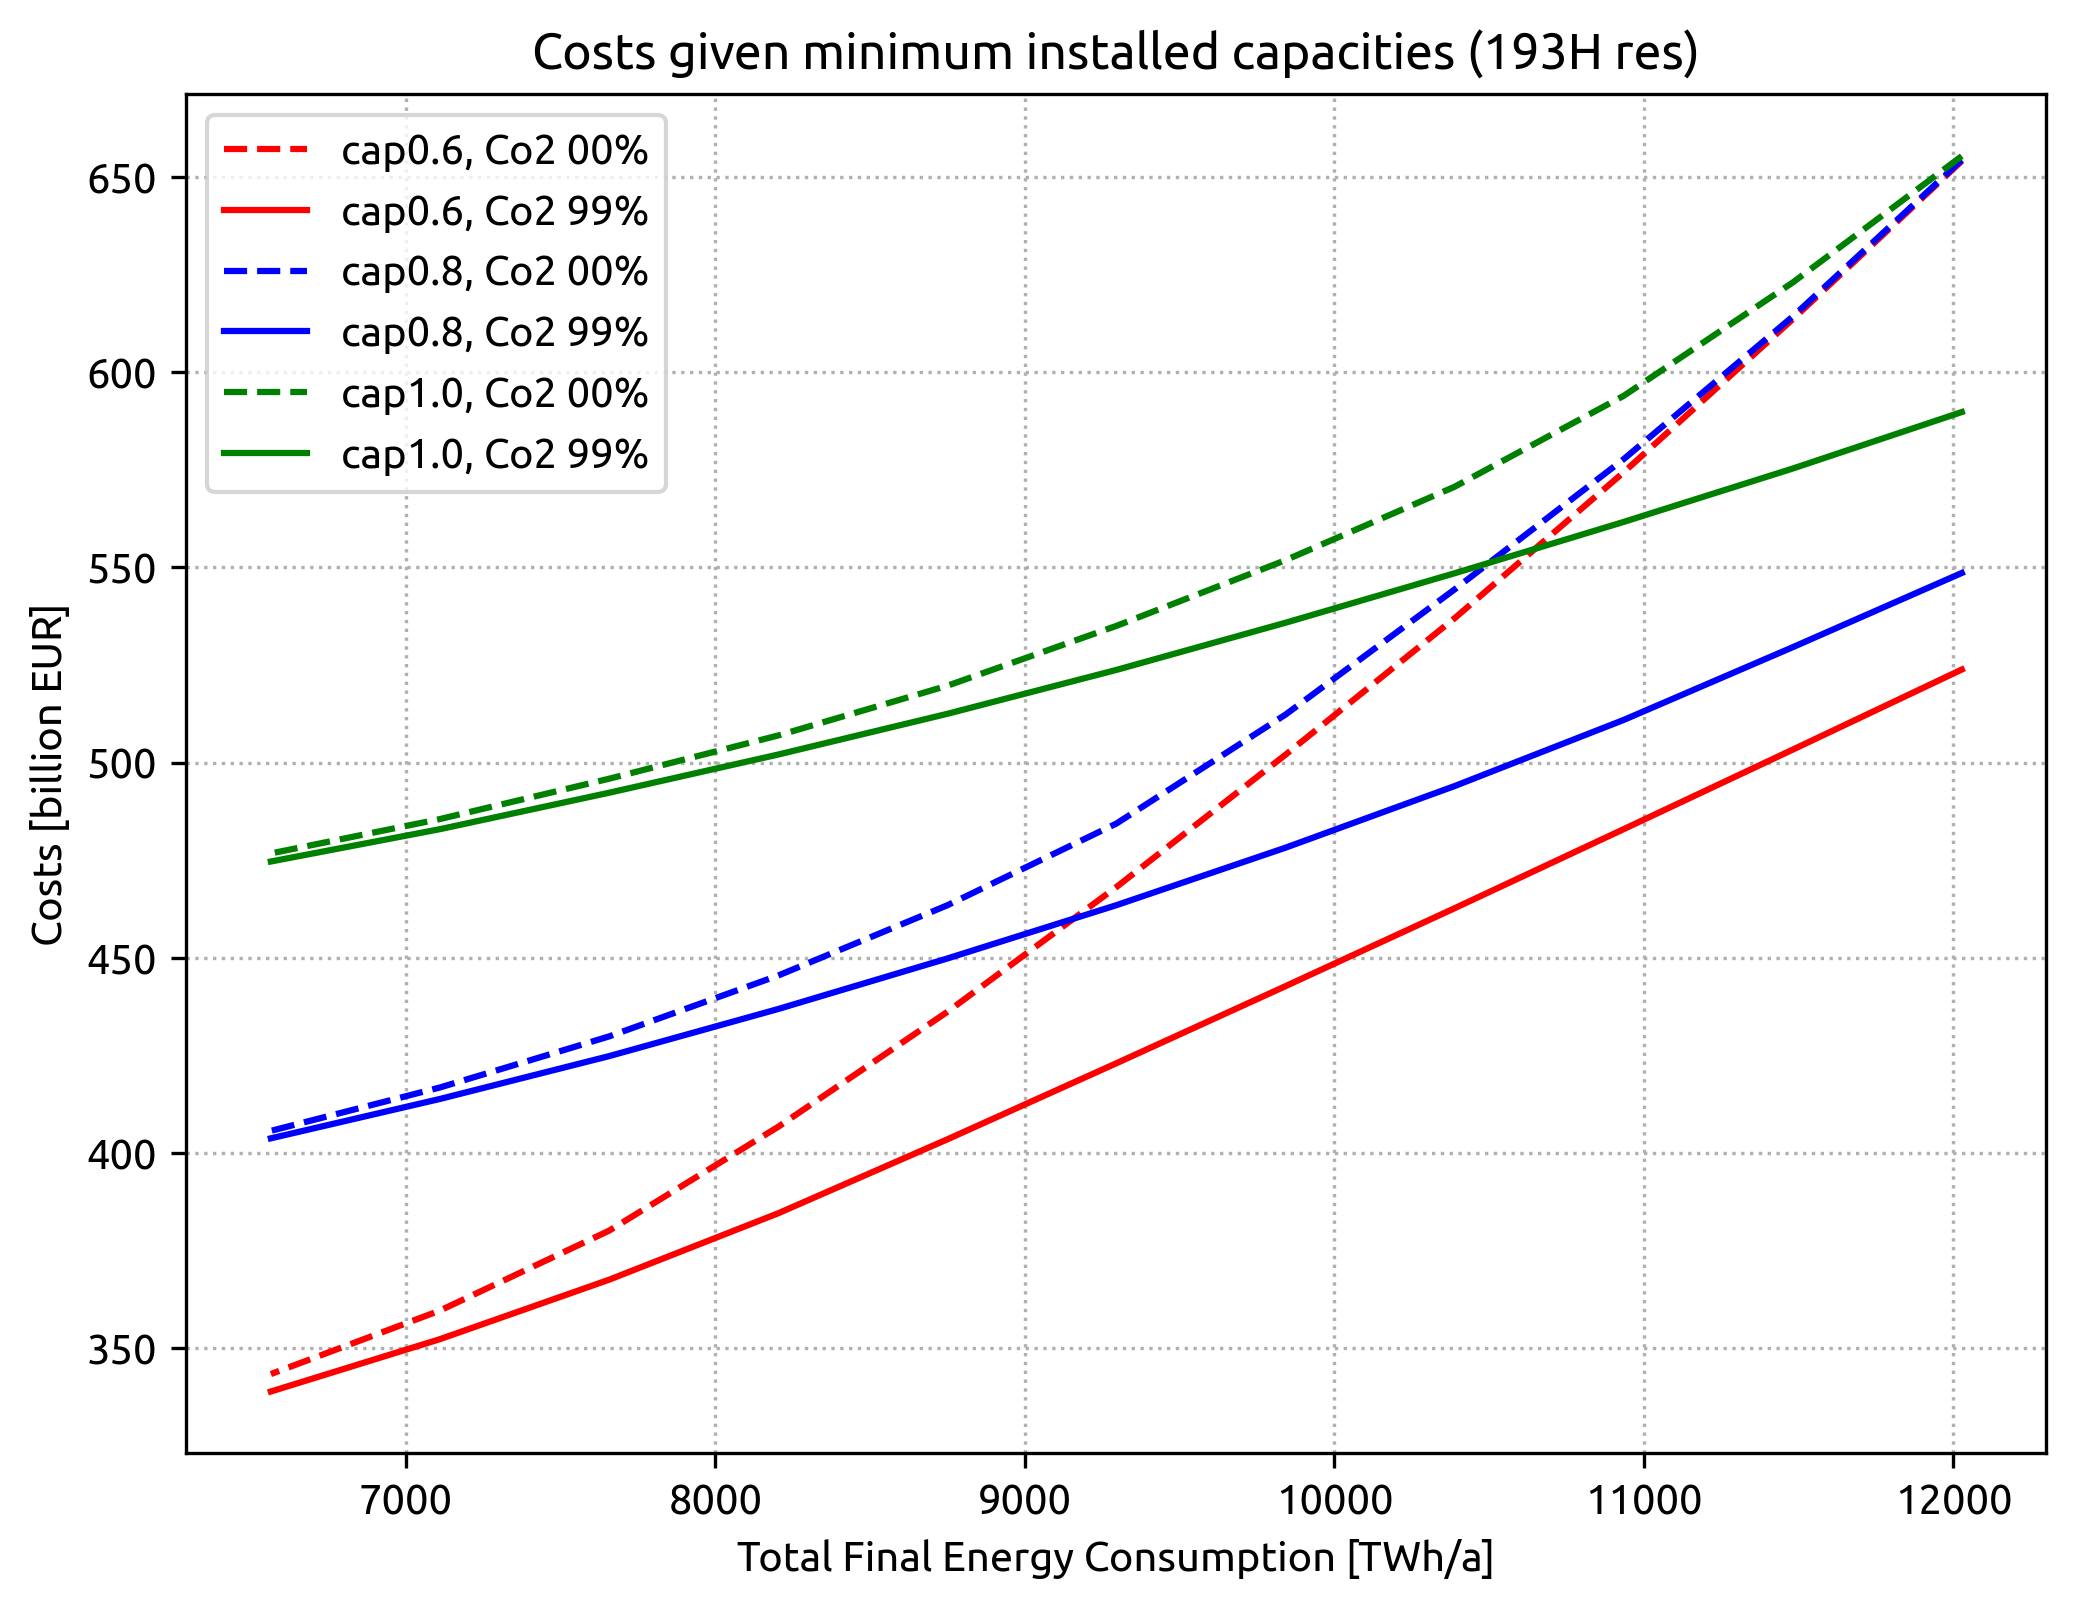

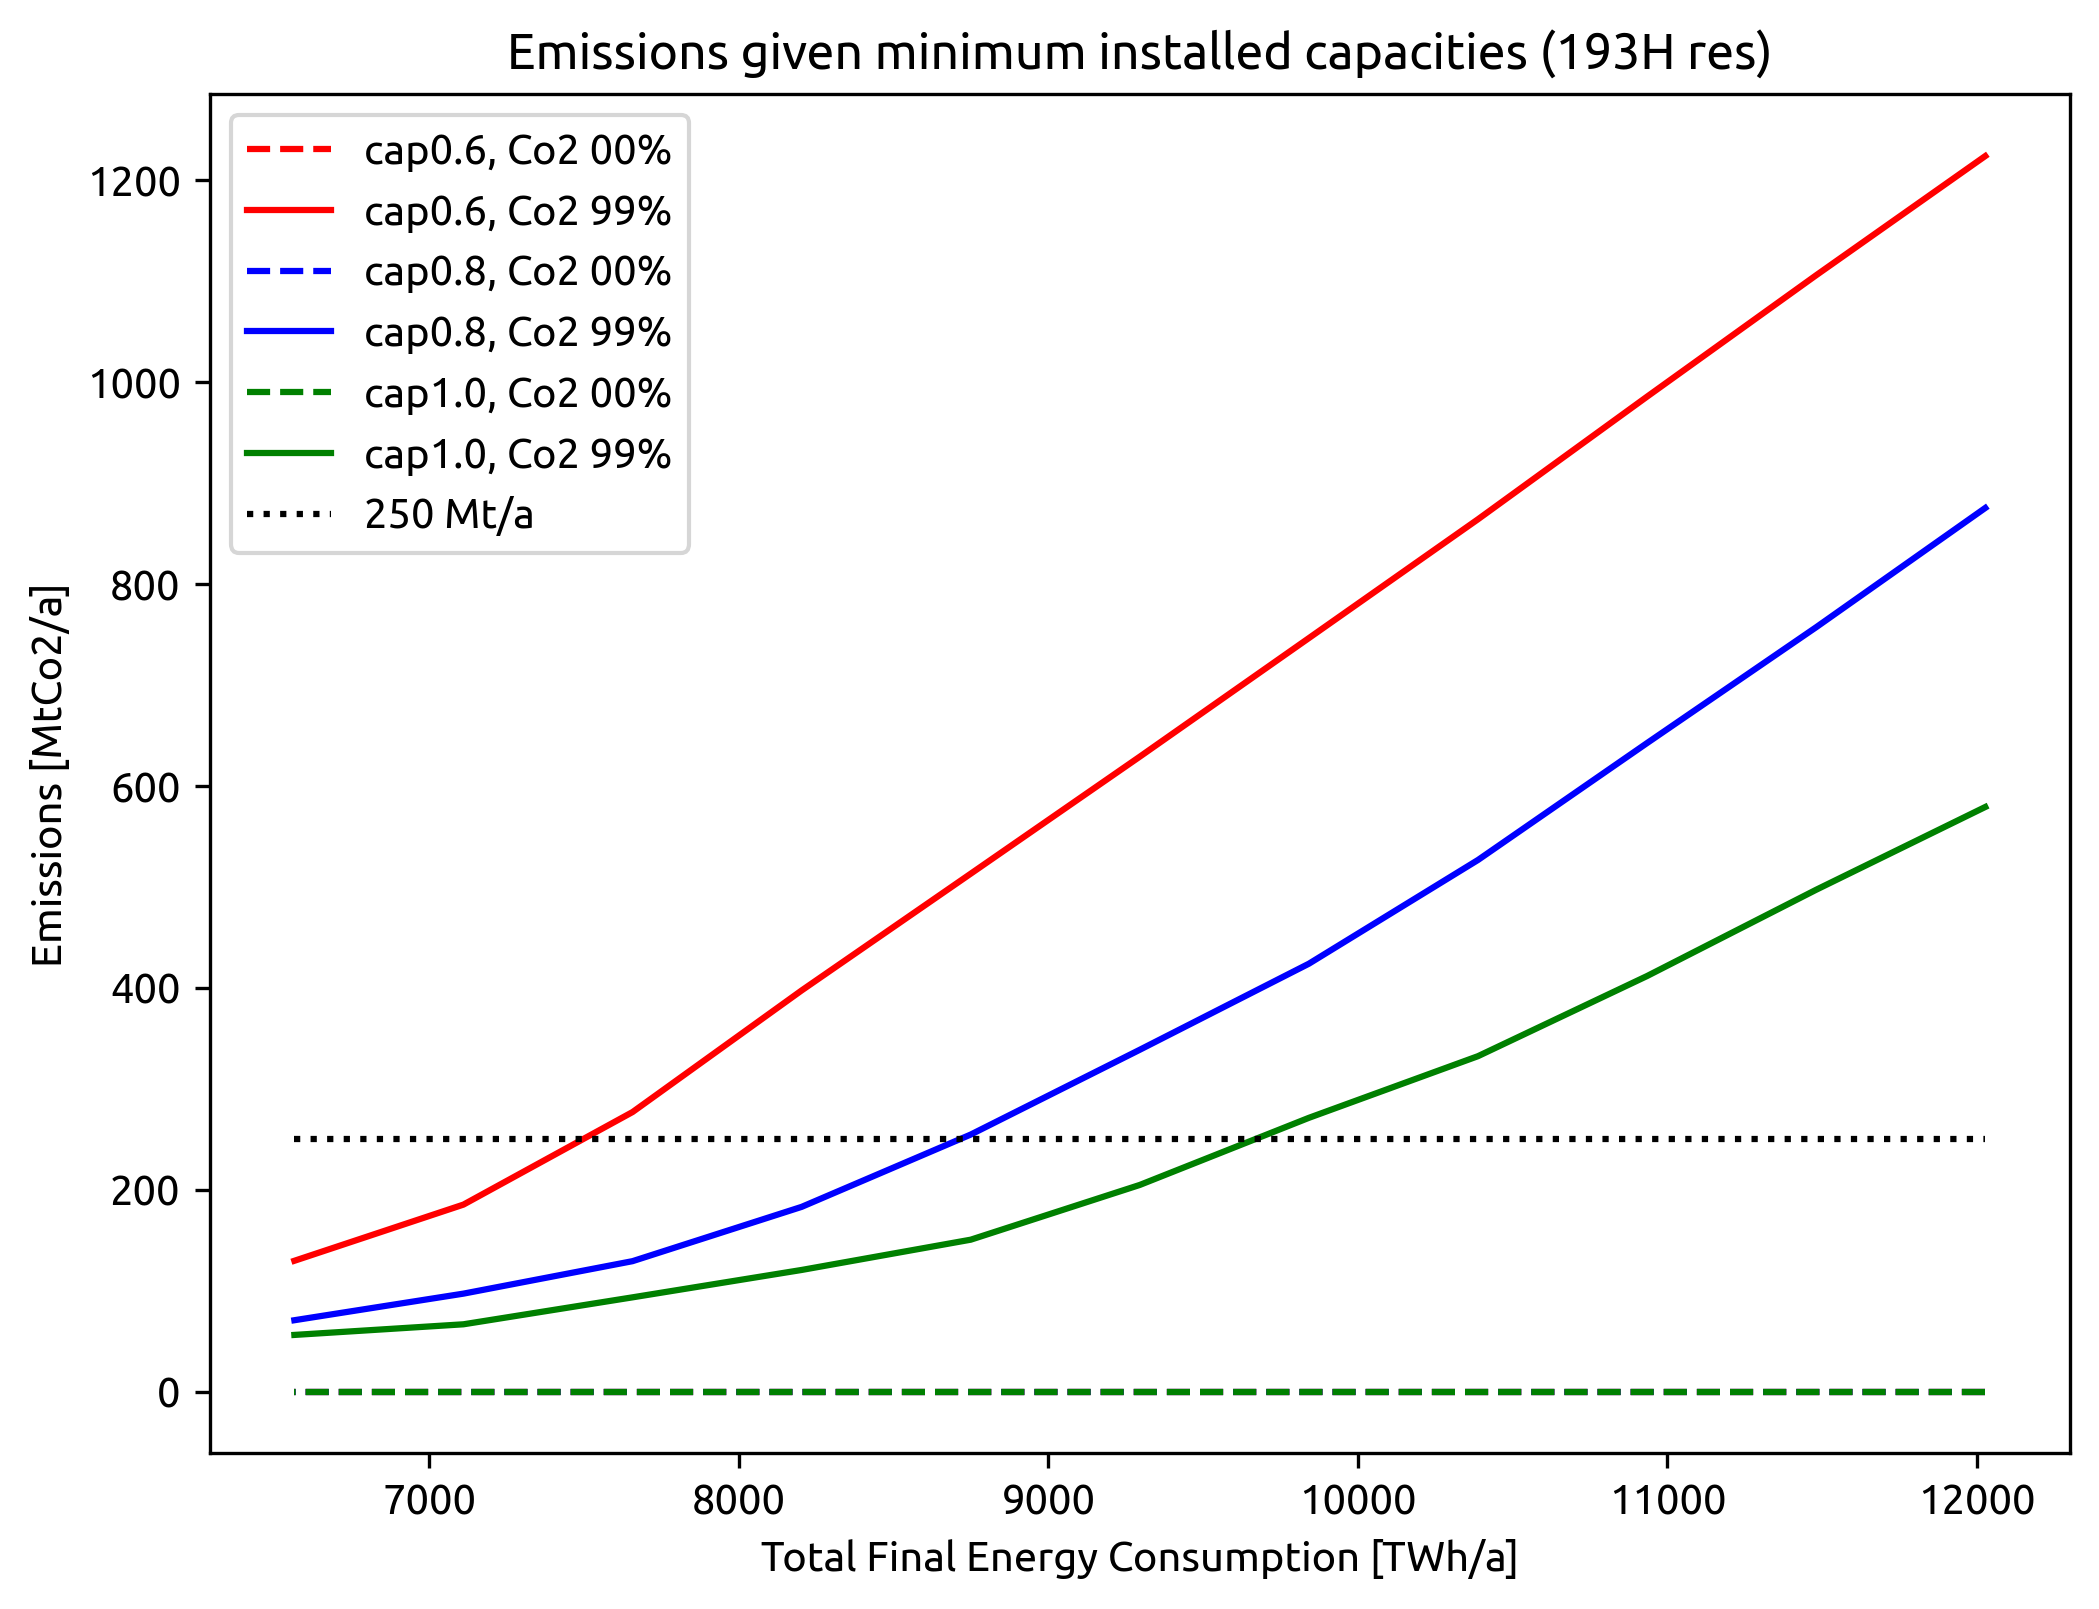

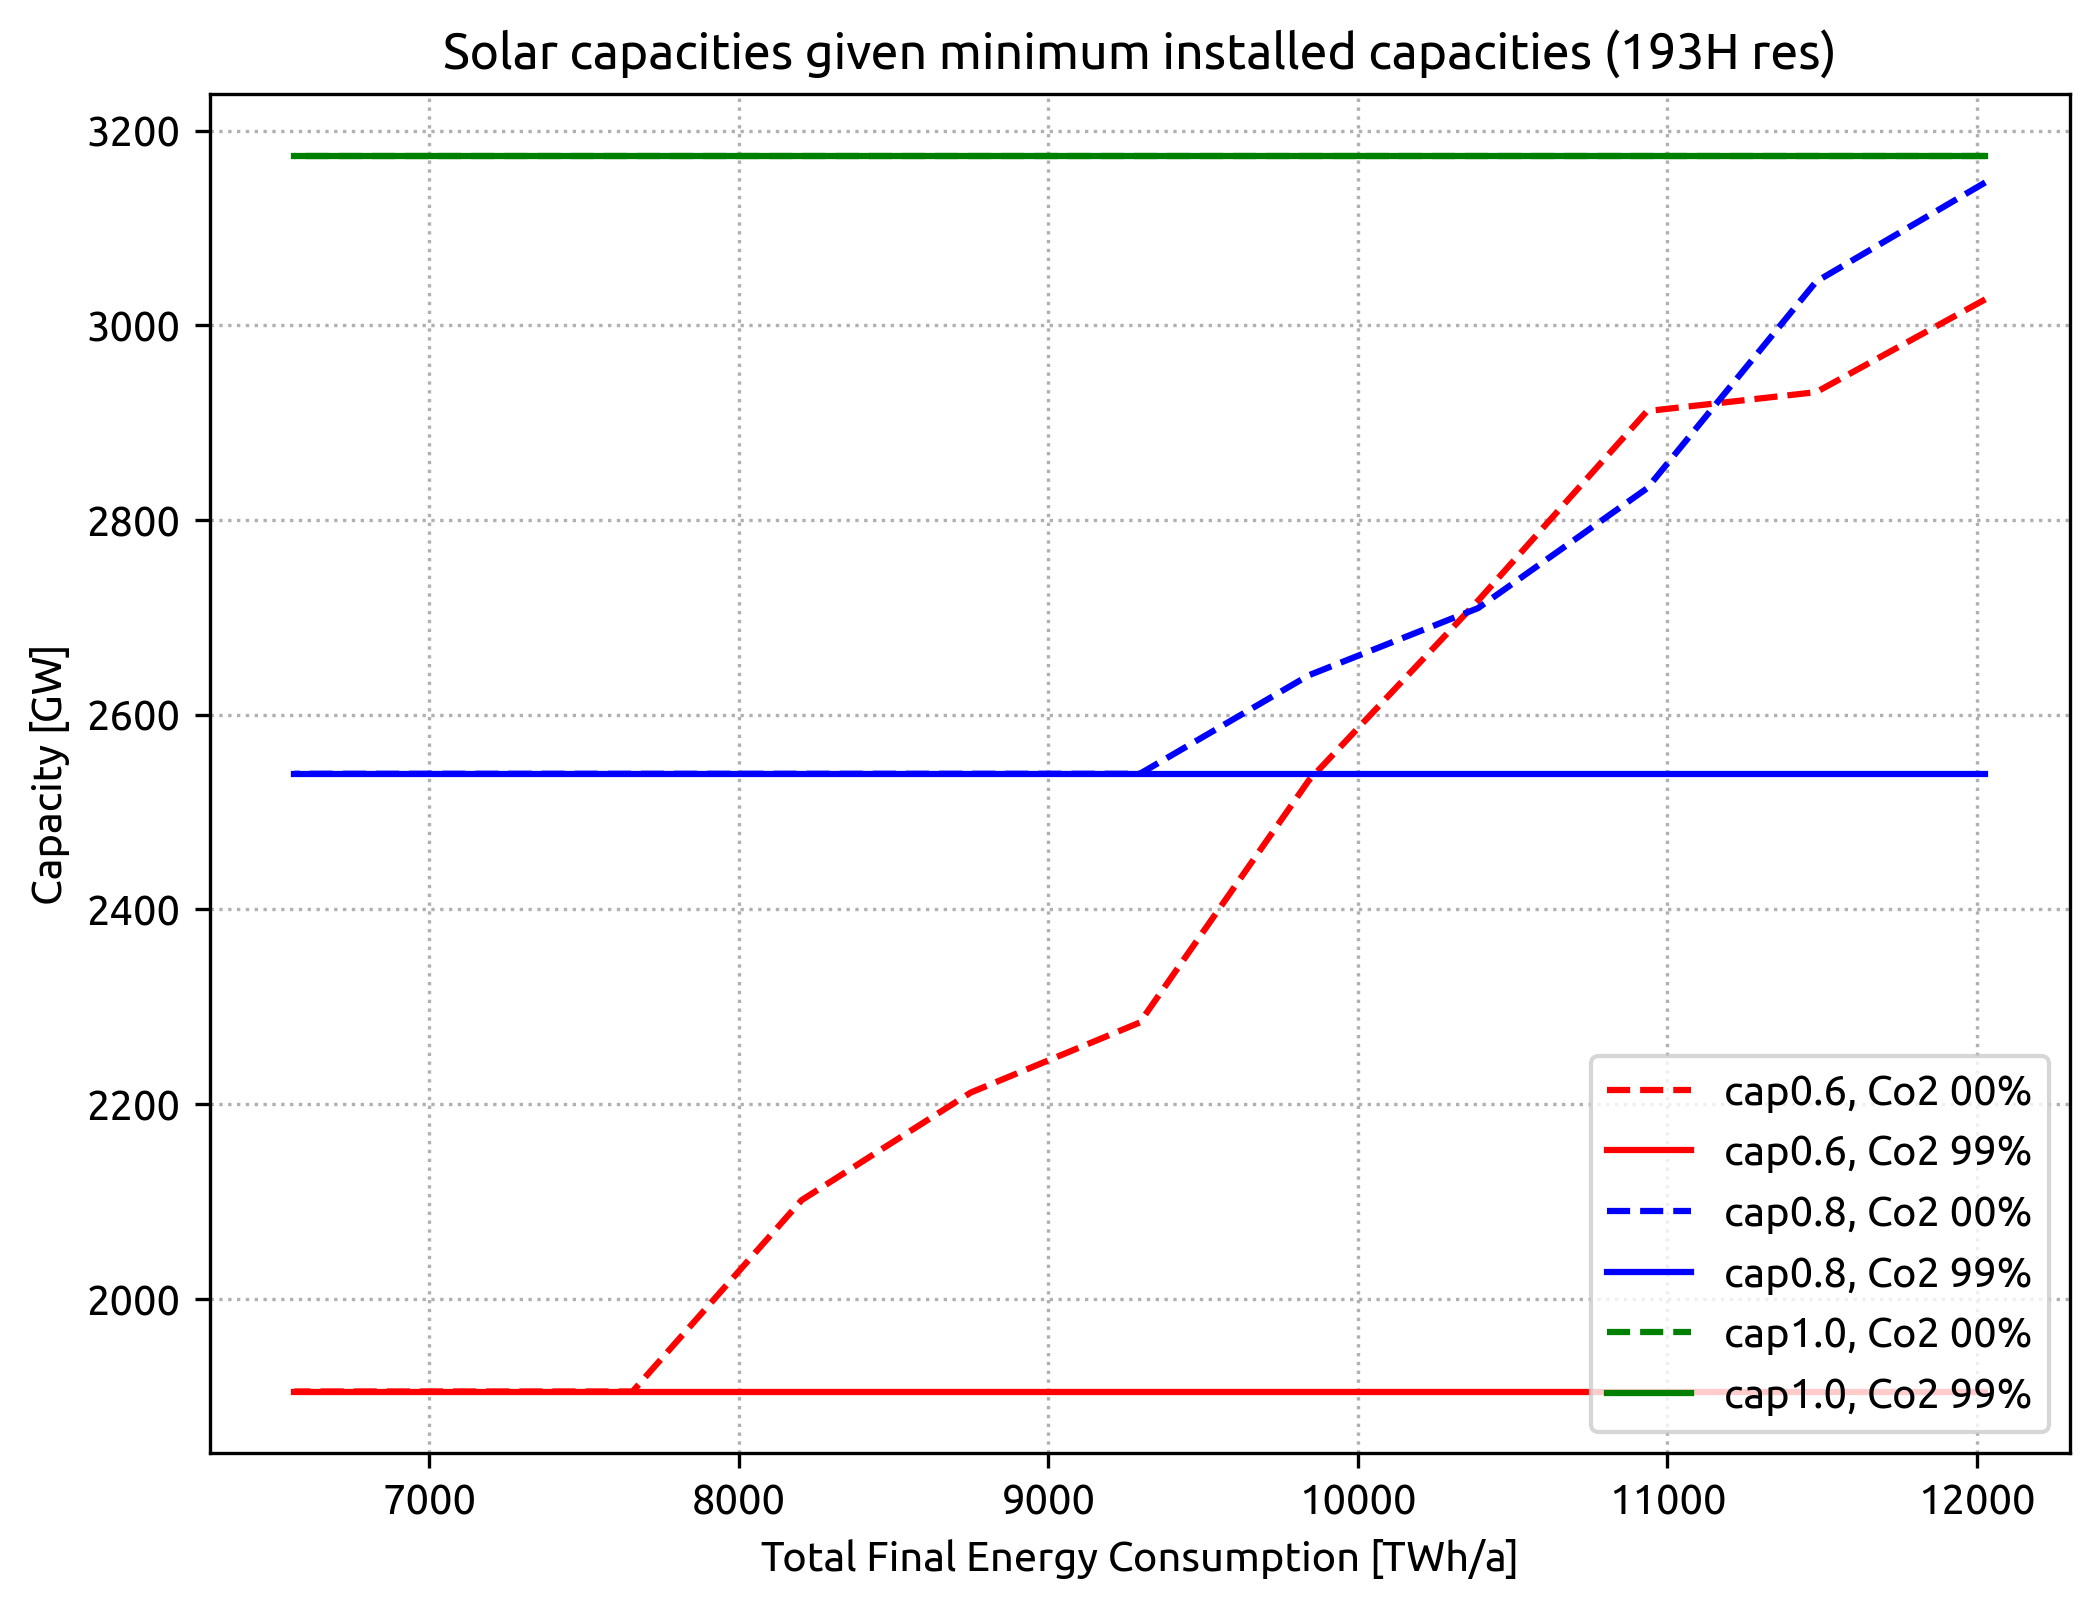

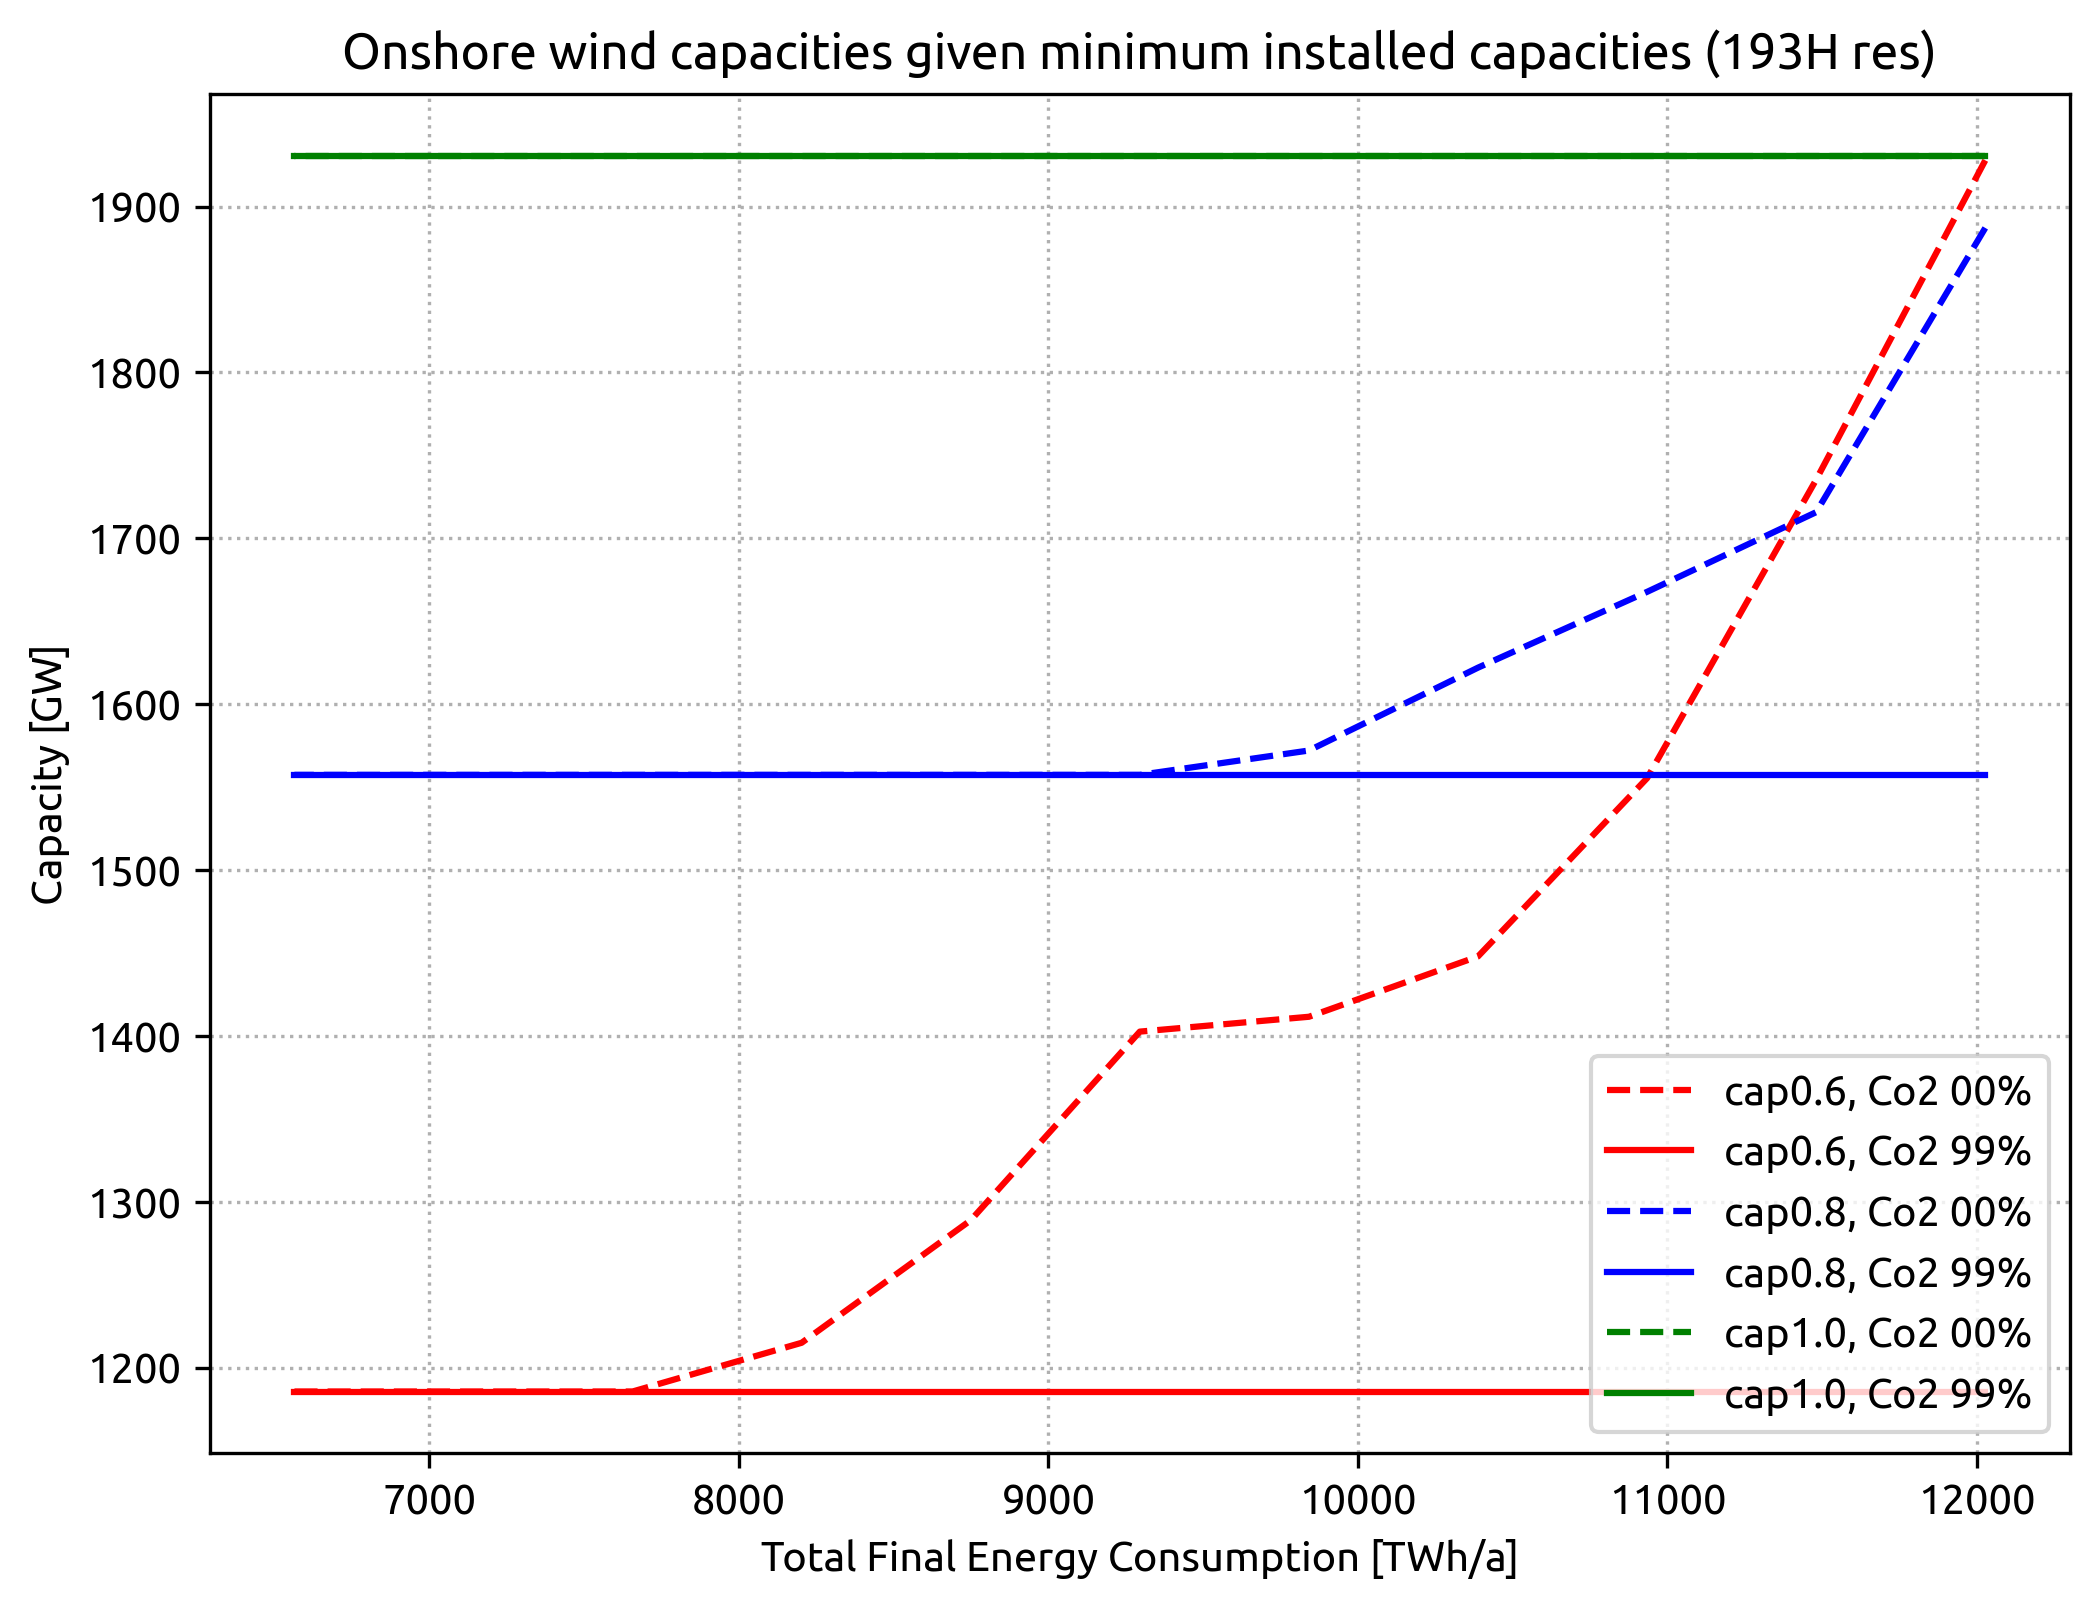

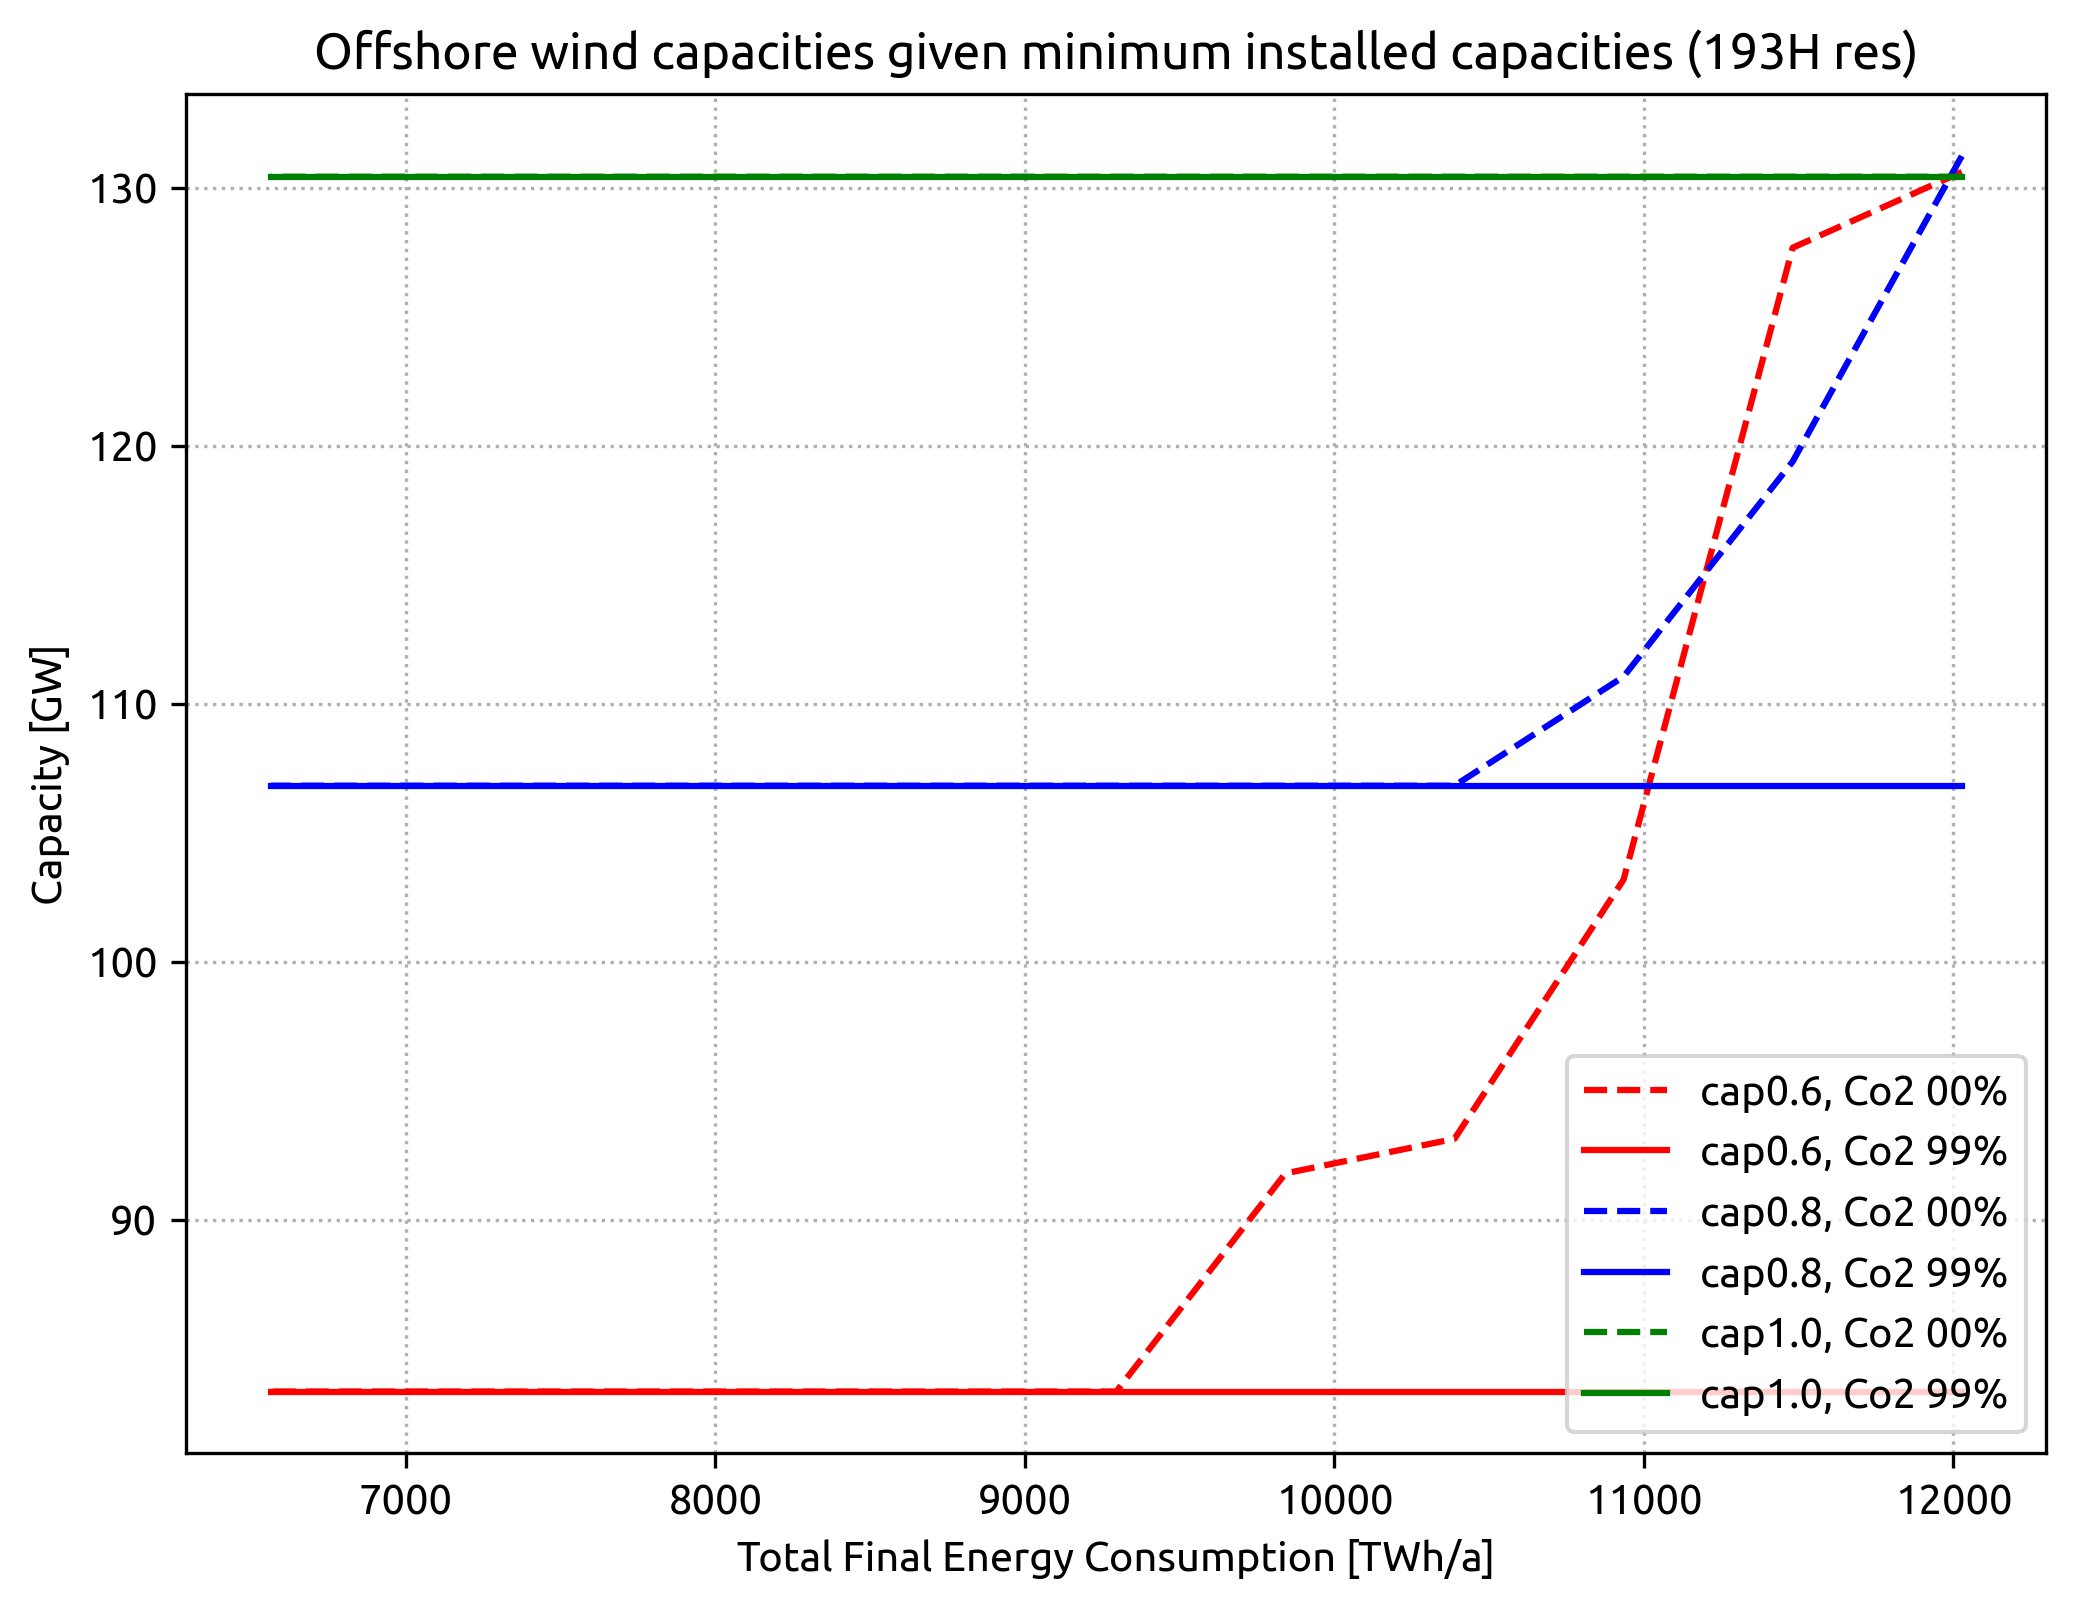

In [193]:
allruns = get_all_runs(runkeys)
plot_costs(allruns,"Costs given minimum installed capacities (193H res)",outdirec+"costs_all.png")
plot_emissions(allruns,"Emissions given minimum installed capacities (193H res)",outdirec+"emissions_all.png")
plot_capacity(allruns,'solar [GW]',"Solar capacities given minimum installed capacities (193H res)",outdirec+"solar_all.png")
plot_capacity(allruns,'onwind [GW]',"Onshore wind capacities given minimum installed capacities (193H res)",outdirec+"onwind_all.png")
plot_capacity(allruns,'offwind [GW]',"Offshore wind capacities given minimum installed capacities (193H res)",outdirec+"offwind_all.png")





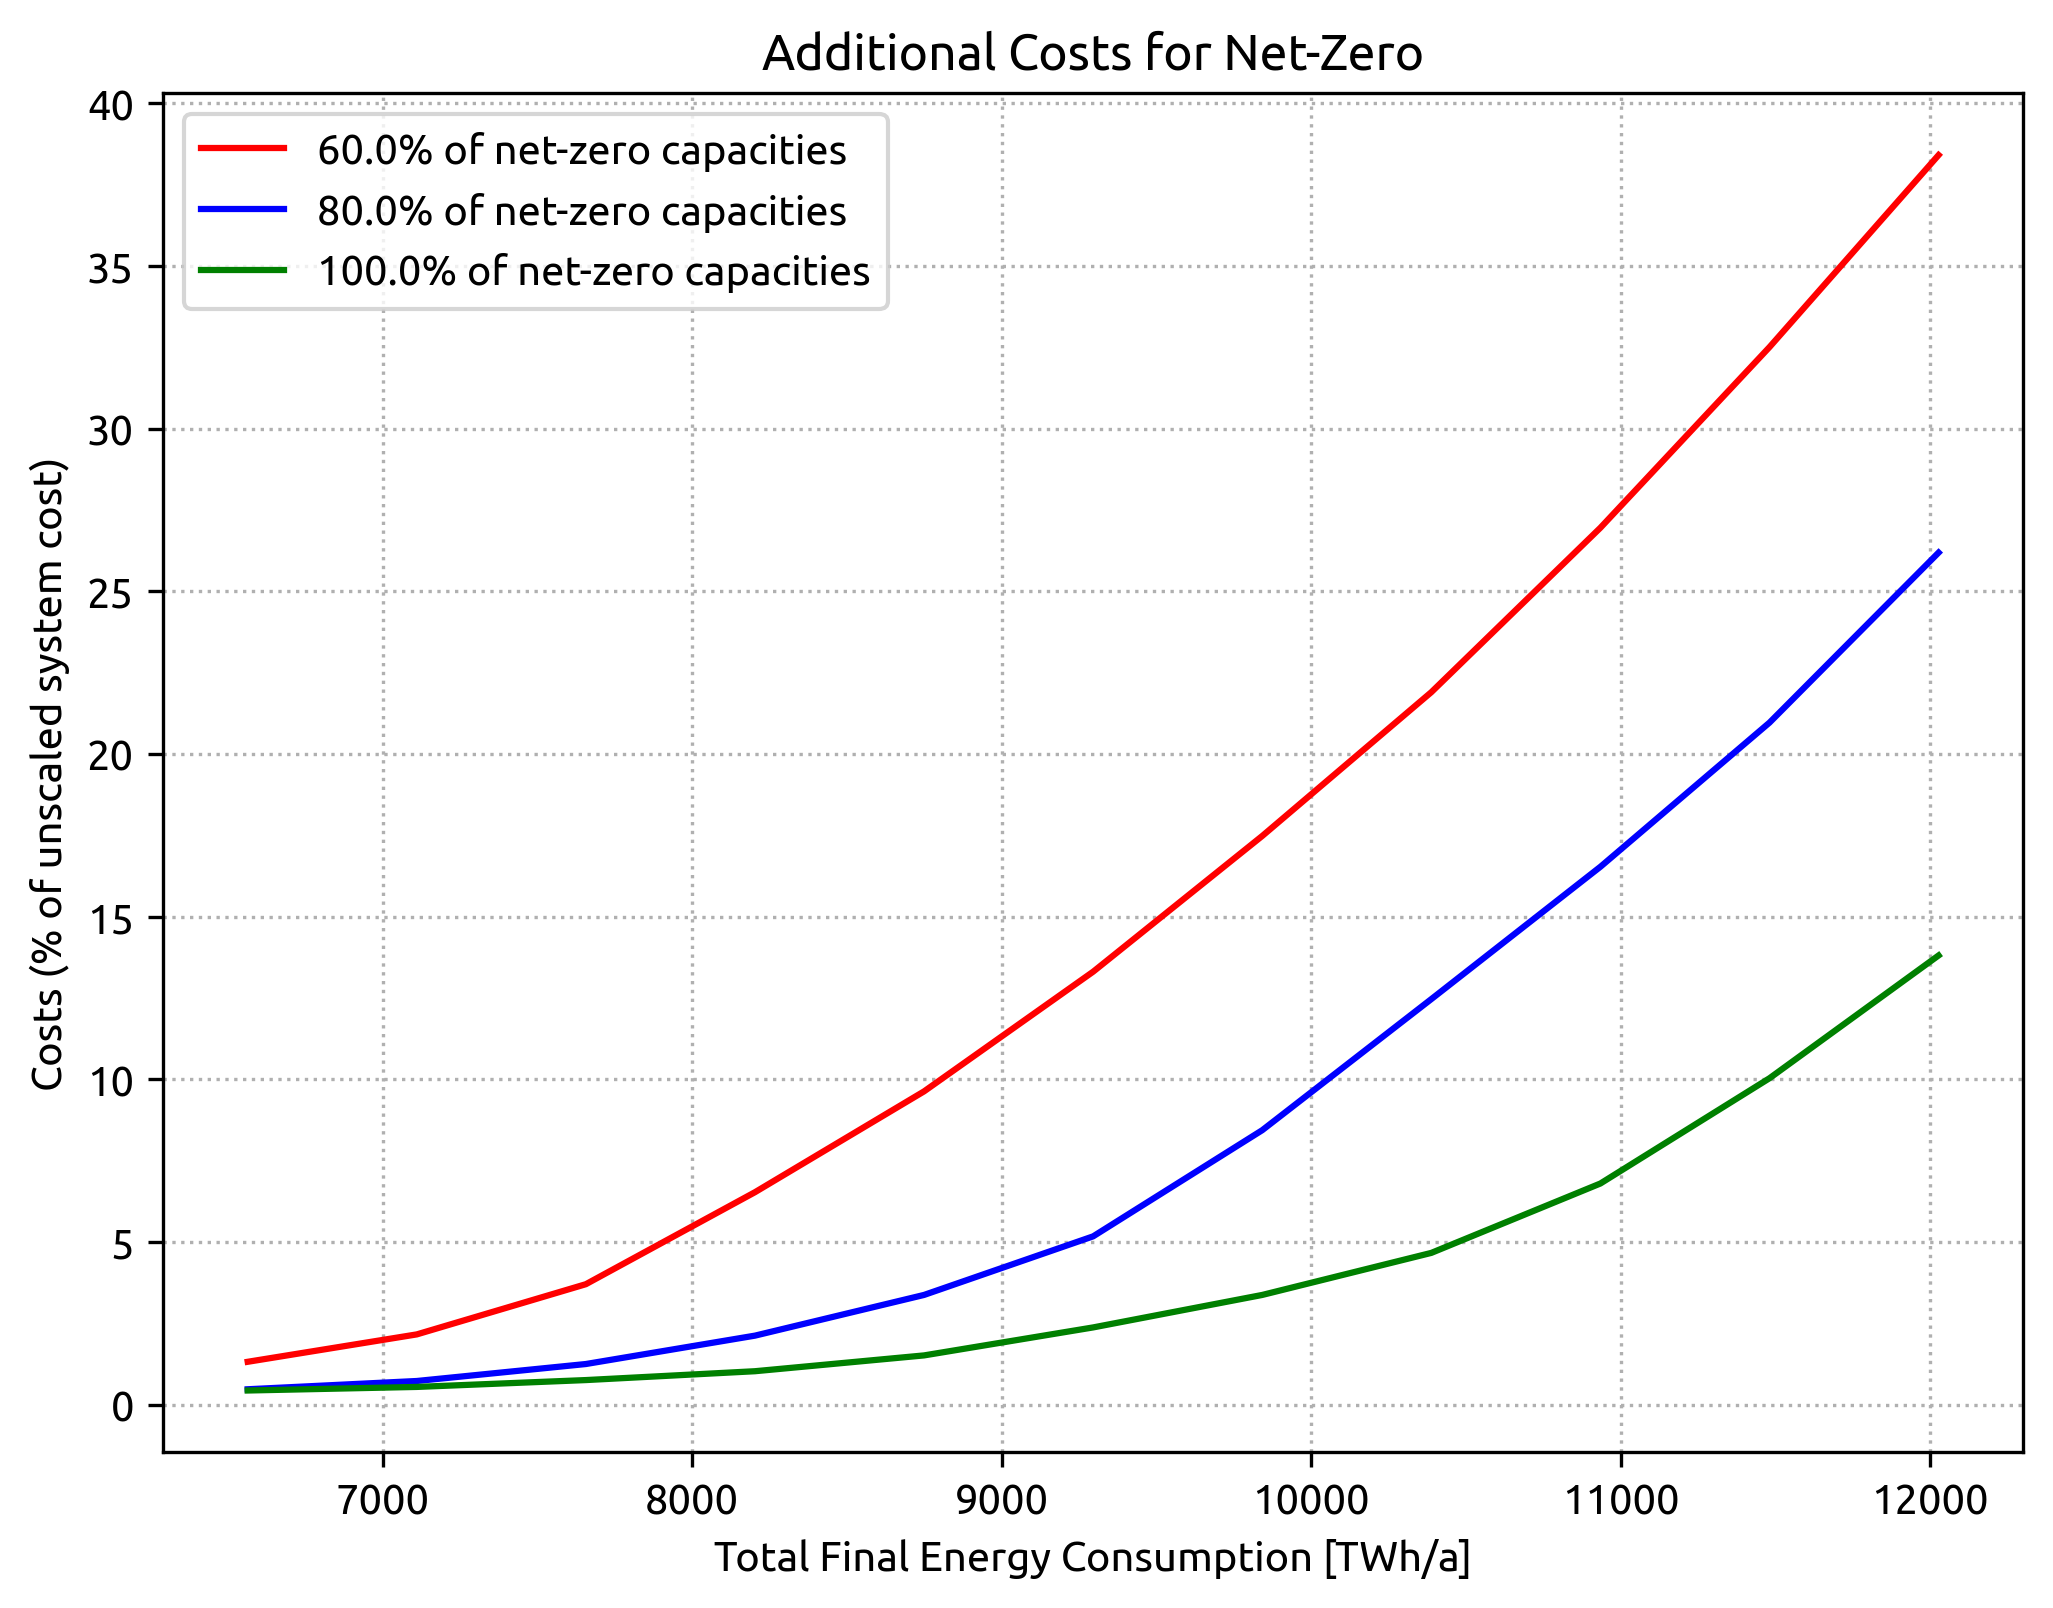

In [194]:

fmt=get_line_formats()
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

for cap in allruns.keys():
    df = allruns[cap]
    ax.plot(df.loc['00']['TFEC [TWh]'],\
            (df.loc['00']['Costs [bEUR]'].values-df.loc['99']['Costs [bEUR]'].values)/df.loc['99']['Costs [bEUR]'].values.min()*100,\
            fmt[cap]['99'],label=str(100*cap)+'% of net-zero capacities')
    #ax.plot(df_net0['costs [billion EUR]'],label='Emissions Cap 0 Mt')

ax.set_title("Additional Costs for Net-Zero")
ax.set_ylabel('Costs (% of unscaled system cost)')
ax.set_xlabel('Total Final Energy Consumption [TWh/a]')

ax.legend() 

ax.set_axisbelow(True)
ax.grid(visible=True,linestyle=":")

fig.savefig(outdirec+"net0_addl_costs_pct.png", bbox_inches='tight')

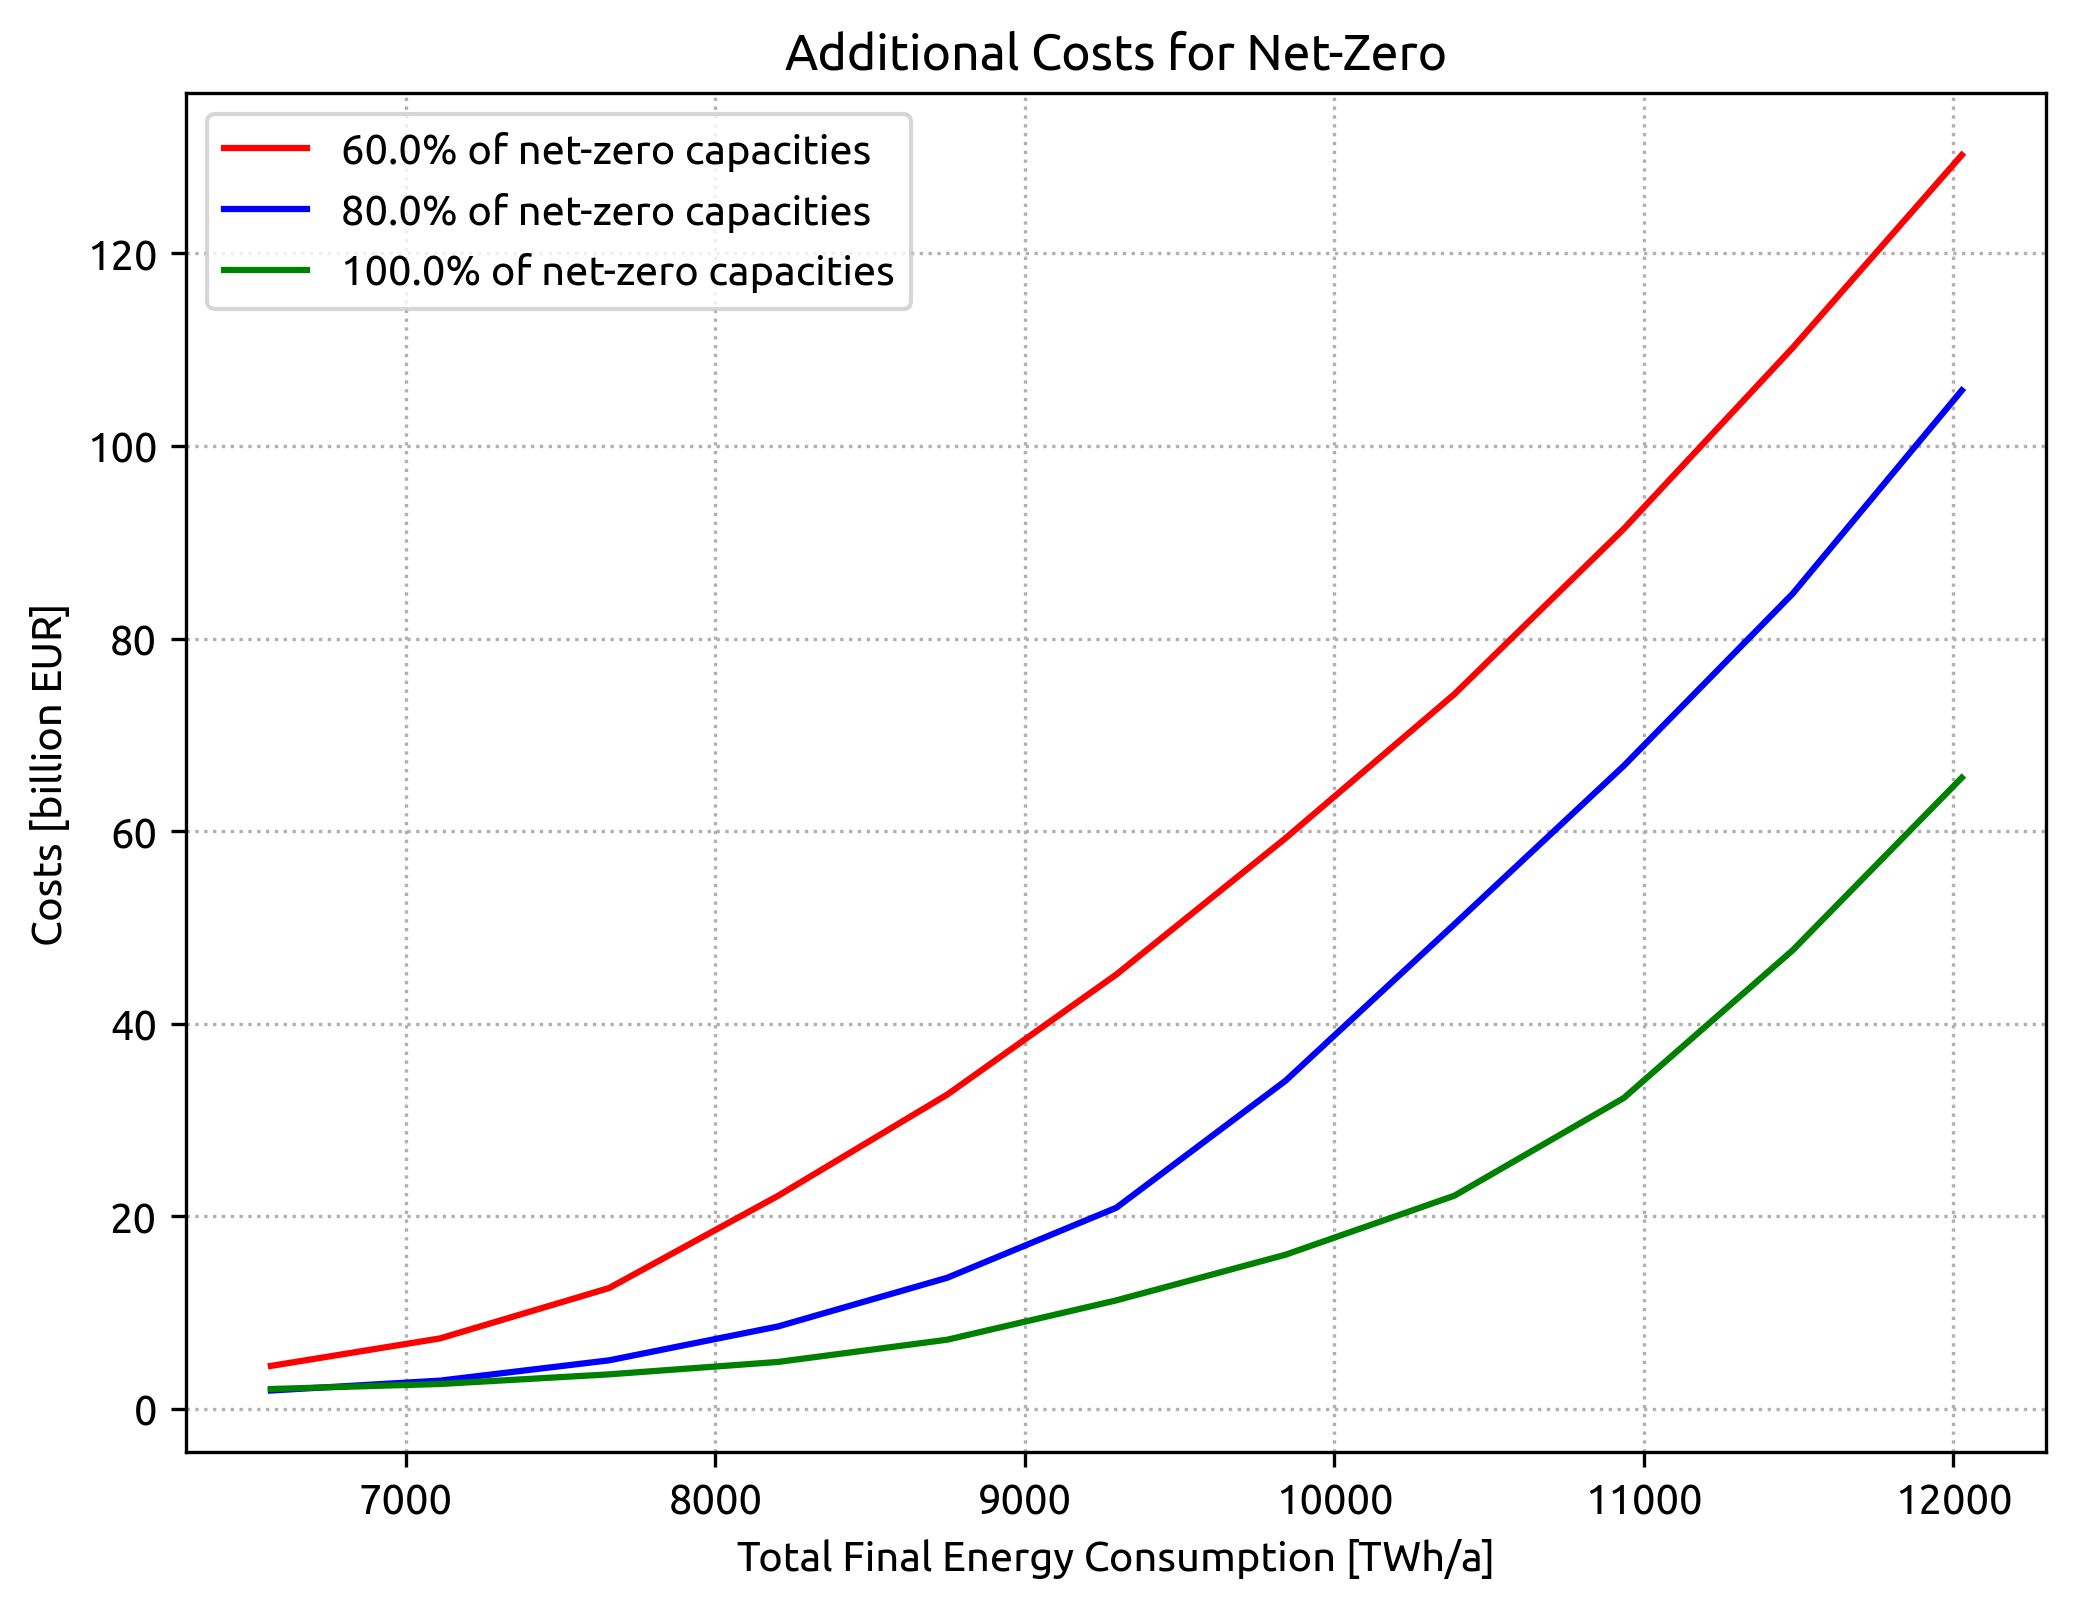

In [195]:

fmt=get_line_formats()
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

for cap in allruns.keys():
    df = allruns[cap]
    ax.plot(df.loc['00']['TFEC [TWh]'],df.loc['00']['Costs [bEUR]'].values-df.loc['99']['Costs [bEUR]'].values,\
            fmt[cap]['99'],label=str(100*cap)+'% of net-zero capacities')
    #ax.plot(df_net0['costs [billion EUR]'],label='Emissions Cap 0 Mt')

ax.set_title("Additional Costs for Net-Zero")
ax.set_ylabel('Costs [billion EUR]')
ax.set_xlabel('Total Final Energy Consumption [TWh/a]')

ax.legend() 

ax.set_axisbelow(True)
ax.grid(visible=True,linestyle=":")

fig.savefig(outdirec+"net0_addl_costs.png", bbox_inches='tight')

In [136]:
df = allruns[1.0]
df.loc['00']['Costs [bEUR]'].values-df.loc['99']['Costs [bEUR]'].values


array([68.20992941, 50.14977554, 34.9206963 , 24.10394102, 16.9174989 ,
       11.98407238,  7.36752883,  4.36467619,  2.86126856,  2.03091398,
        1.61244942])

In [137]:
x6=allruns[0.6].loc['99']['Emissions [MtCo2/a]']
min(x6)/max(x6)

0.12047632607038228

# Analyze capacity&emissions variations


/tmp/ipykernel_22467/171389104.py:6: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



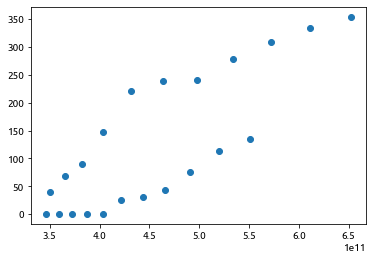

In [138]:
scen = 'demand_sweep_cap80pct'
cost = load_pypsa_csv('results/'+scen+'/csvs/costs.csv').sum()
co2price = load_pypsa_csv('results/'+scen+'/csvs/prices.csv').loc['co2']*-1
plt.scatter(cost,co2price)


In [157]:
n.stores.carrier.unique()

array(['co2', 'co2 stored', 'gas', 'H2', 'battery', 'Li ion',
       'residential rural water tanks', 'services rural water tanks',
       'residential urban decentral water tanks',
       'services urban decentral water tanks',
       'urban central water tanks', 'biogas', 'solid biomass', 'oil',
       'home battery'], dtype=object)

In [140]:
pren = pypsa.Network('results/demand_sweep_cap70pct/prenetworks/elec_sc_noscaling_s_64_lv1.5__Co2L0p10-193H-T-H-B-I-A_2050.nc')

INFO:pypsa.io:Imported network elec_sc_noscaling_s_64_lv1.5__Co2L0p10-193H-T-H-B-I-A_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [141]:
n.stores

,bus,carrier,e_nom_extendable,e_cyclic,capital_cost,e_initial,e_min_pu,e_nom,e_nom_max,lifetime,marginal_cost,standing_loss,e_nom_opt,type,e_nom_min,e_max_pu,e_initial_per_period,e_cyclic_per_period,p_set,q_set,sign,build_year
Store,,,,,,,,,,,,,,,,,,,,,,
co2 atmosphere,co2 atmosphere,co2,True,False,0.000000,0.0,-1.0,0.0,inf,inf,0.009920,0.0,3.792036e+07,,0.0,1.0,False,True,0.0,0.0,1.0,0
co2 stored,co2 stored,co2 stored,True,False,10.000000,0.0,0.0,0.0,inf,inf,0.010793,0.0,2.000000e+08,,0.0,1.0,False,True,0.0,0.0,1.0,0
EU gas Store,EU gas,gas,True,True,0.000000,0.0,0.0,0.0,inf,inf,0.009380,0.0,2.485942e+09,,0.0,1.0,False,True,0.0,0.0,1.0,0
DE1 0 H2 Store,DE1 0 H2,H2,True,True,84.096918,0.0,0.0,0.0,1.000000e+09,100.0,0.009412,0.0,7.160014e+06,,0.0,1.0,False,True,0.0,0.0,1.0,0
DK1 0 H2 Store,DK1 0 H2,H2,True,True,84.096918,0.0,0.0,0.0,2.054275e+08,100.0,0.010034,0.0,2.952086e+06,,0.0,1.0,False,True,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RO1 0 home battery,RO1 0 home battery,home battery,True,True,8750.877557,0.0,0.0,0.0,inf,30.0,0.009297,0.0,2.337648e-02,,0.0,1.0,False,True,0.0,0.0,1.0,0
RS1 0 home battery,RS1 0 home battery,home battery,True,True,8750.877557,0.0,0.0,0.0,inf,30.0,0.010038,0.0,2.388255e-02,,0.0,1.0,False,True,0.0,0.0,1.0,0
SE2 0 home battery,SE2 0 home battery,home battery,True,True,8750.877557,0.0,0.0,0.0,inf,30.0,0.010294,0.0,2.340347e-02,,0.0,1.0,False,True,0.0,0.0,1.0,0


In [142]:
def get_runs_prefix(prefix):
    return glob.glob('results/'+prefix+'*')

baseline_direc = "results/2050_Baseline_Capacities"
#low_demand_direcs = ["results/2050_low_demand_fixed_capacity_test
cap_lim_prefix_10pct = "capacity_sweep_p10"
cap_lim_prefix_0pct = "capacity_sweep_net0"


dirs_net0 = get_runs_prefix(cap_lim_prefix_0pct)
dirs_10pct = get_runs_prefix(cap_lim_prefix_10pct)

dirs_10pct

['results/capacity_sweep_p10_50pct',
 'results/capacity_sweep_p10_100pct',
 'results/capacity_sweep_p10_60pct',
 'results/capacity_sweep_p10_90pct',
 'results/capacity_sweep_p10_70pct',
 'results/capacity_sweep_p10_80pct']

In [143]:
def get_run_dict(dirs):
    run_dict = {}
    for d in dirs:
        with open(d+'/configs/config.yaml', 'r') as stream:
            config = yaml.safe_load(stream)
        cap_scal = config['sector']['minimum_capacities']['min_cap_ratios']
        run_dict[cap_scal] = d
    return run_dict


    

run_dict_10pct = get_run_dict(dirs_10pct)
run_dict_net0 = get_run_dict(dirs_net0)


In [144]:
# costs
# emissions
# renewable capacities

def add_costs(df,run_dict):
    df['costs [billion EUR]'] = np.nan
    for i in df.index:
        csv = pd.read_csv(run_dict[i]+'/csvs/costs.csv',skiprows=lambda x: x in [0,1,3,4])
        csv.columns = [1,2,3,4]
        df['costs [billion EUR]'][i] = csv.sum()[4]/1e9
    return df

def add_emissions(df,run_dict):
    df['emissions [MtCO2/a]'] = np.nan
    for i in df.index:
        csv = pd.read_csv(run_dict[i]+'/csvs/supply_energy.csv',skiprows=lambda x: x in [0,1,3,4])
        csv.columns = [1,2,3,4]
        csv.set_index([1,2,3],inplace=True)
        df['emissions [MtCO2/a]'][i] = csv.loc['co2','stores','co2'][4]/1e6 * -1
    return df

def add_capacities(df,run_dict):
    df['solar [GW]'] = np.nan
    df['onwind [GW]'] = np.nan
    df['offwind-ac [GW]'] = np.nan
    df['offwind-dc [GW]'] = np.nan
    df['offwind [GW]'] = np.nan

    for i in df.index:
        csv = pd.read_csv(run_dict[i]+'/csvs/capacities.csv',skiprows=lambda x: x in [0,1,3,4])
        csv.columns = [1,2,3]
        csv.set_index([1,2],inplace=True)
        df['solar [GW]'][i] = csv.loc['generators','solar'][3]/1e3
        df['onwind [GW]'][i] = csv.loc['generators','onwind'][3]/1e3
        df['offwind-ac [GW]'][i] = csv.loc['generators','offwind-ac'][3]/1e3
        df['offwind-dc [GW]'][i] = csv.loc['generators','offwind-dc'][3]/1e3 
        df['offwind [GW]'][i] = df['offwind-ac [GW]'][i] + df['offwind-dc [GW]'][i]

    return df

def add_generation(df,run_dict):
    df['solar [TWh]'] = np.nan
    df['onwind [TWh]'] = np.nan
    df['offwind-ac [TWh]'] = np.nan
    df['offwind-dc [TWh]'] = np.nan


    for i in df.index:
        csv = pd.read_csv(run_dict[i]+'/csvs/supply_energy.csv',skiprows=lambda x: x in [0,1,3,4])
        csv.columns = [1,2,3,4]
        csv.set_index([1,2,3],inplace=True)
        df['solar [TWh]'][i] = csv.loc['AC','generators','solar'][4]/1e6
        df['onwind [TWh]'][i] = csv.loc['AC','generators','onwind'][4]/1e6
        df['offwind-ac [TWh]'][i] = csv.loc['AC','generators','offwind-ac'][4]/1e6
        df['offwind-dc [TWh]'][i] = csv.loc['AC','generators','offwind-dc'][4]/1e6 
    return df

def add_all_stats(run_dict):
    df = pd.DataFrame(index=run_dict.keys()).sort_index()
    df = add_costs(df,run_dict)
    df = add_emissions(df,run_dict)
    df = add_capacities(df,run_dict)
    df = add_generation(df,run_dict)
    return df

#df_10pct = #,columns=['costs [billion EUR]','emissions [MtCO2/a]','solar [GW]','onwind [GW]','offwind [GW]']).sort_index()
df_10pct = add_all_stats(run_dict_10pct)
df_net0 = add_all_stats(run_dict_net0)
df_net0

,costs [billion EUR],emissions [MtCO2/a],solar [GW],onwind [GW],offwind-ac [GW],offwind-dc [GW],offwind [GW],solar [TWh],onwind [TWh],offwind-ac [TWh],offwind-dc [TWh]
0.5,364.867004,-1.562876e-14,1593.978474,891.556558,6.827706,16.171171,22.998877,1935.924735,2533.090276,24.944267,69.407312
0.6,370.374842,-1.878642e-09,1689.480682,902.708946,8.193254,19.405409,27.598663,1995.392021,2471.402868,30.014147,83.368720
0.7,392.791098,-3.604667e-09,1912.935848,1049.057208,9.558792,22.639641,32.198433,2077.147504,2475.426019,26.202681,73.381577
0.8,421.338954,-5.921855e-07,2186.212395,1198.922521,10.924333,25.873876,36.798209,2150.999645,2358.166910,27.579369,54.525251
0.9,450.310658,-7.579991e-07,2459.488944,1348.787836,12.289875,29.108110,41.397985,2244.777052,2225.492244,25.724188,47.437161
1.0,479.427668,-3.376046e-07,2732.765494,1498.653152,13.655417,32.342344,45.997761,2296.185561,2131.101640,26.232220,42.237607


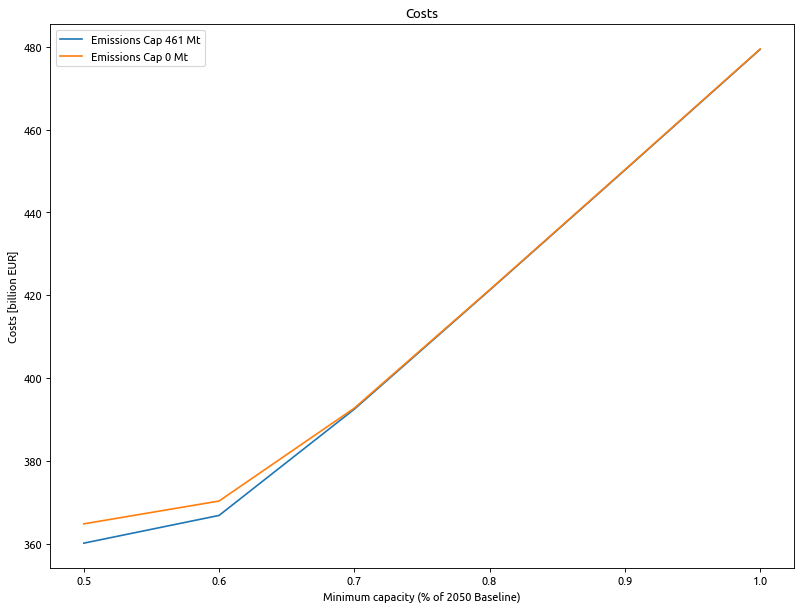

In [145]:
fig, ax = plt.subplots(figsize=(12, 9), dpi=80)
ax.plot(df_10pct['costs [billion EUR]'],label='Emissions Cap 461 Mt')
ax.plot(df_net0['costs [billion EUR]'],label='Emissions Cap 0 Mt')

ax.set_title('Costs')
ax.set_ylabel('Costs [billion EUR]')
ax.set_xlabel('Minimum capacity (% of 2050 Baseline)')
ax.legend()
fig.savefig('results/fix_capac_analysis/vary_cap+emissions/costs.png', bbox_inches='tight')


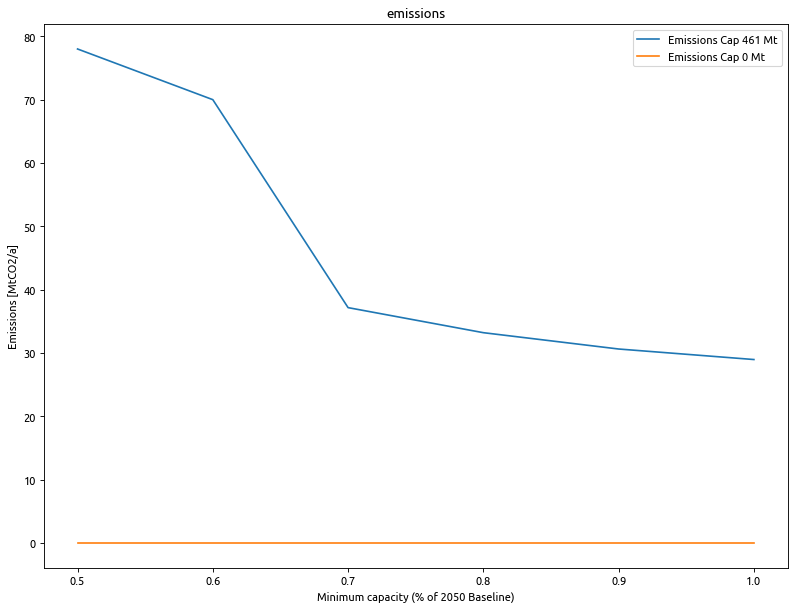

In [146]:
fig, ax = plt.subplots(figsize=(12, 9), dpi=80)
ax.plot(df_10pct['emissions [MtCO2/a]'],label='Emissions Cap 461 Mt')
ax.plot(df_net0['emissions [MtCO2/a]'],label='Emissions Cap 0 Mt')

ax.set_title('emissions')
ax.set_ylabel('Emissions [MtCO2/a]')
ax.set_xlabel('Minimum capacity (% of 2050 Baseline)')
ax.legend()
fig.savefig('results/fix_capac_analysis/vary_cap+emissions/emissions.png', bbox_inches='tight')


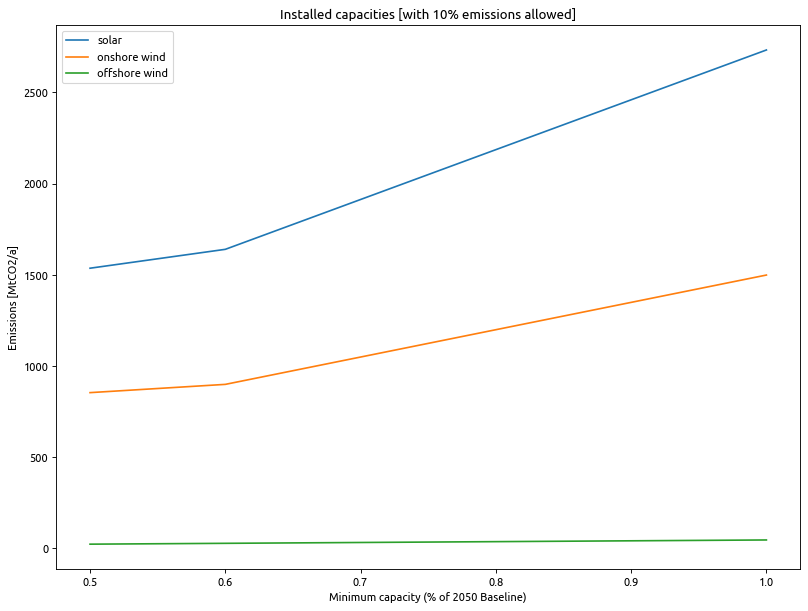

In [147]:
fig, ax = plt.subplots(figsize=(12, 9), dpi=80)

ax.plot(df_10pct[['solar [GW]','onwind [GW]','offwind [GW]']], label = ['solar','onshore wind','offshore wind'])
ax.set_title('Installed capacities [with 10% emissions allowed]')
ax.set_ylabel('Emissions [MtCO2/a]')
ax.set_xlabel('Minimum capacity (% of 2050 Baseline)')
ax.legend()
fig.savefig('results/fix_capac_analysis/vary_cap+emissions/capacities.png', bbox_inches='tight')


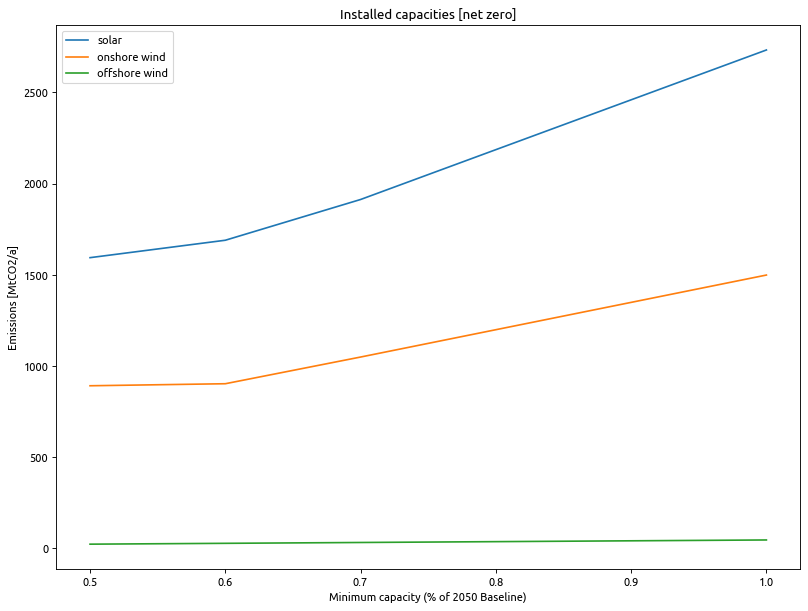

In [148]:

fig, ax = plt.subplots(figsize=(12, 9), dpi=80)
ax.plot(df_net0[['solar [GW]','onwind [GW]','offwind [GW]']], label = ['solar','onshore wind','offshore wind'])
ax.set_title('Installed capacities [net zero]')
ax.set_ylabel('Emissions [MtCO2/a]')
ax.set_xlabel('Minimum capacity (% of 2050 Baseline)')
ax.legend()
fig.savefig('results/fix_capac_analysis/vary_cap+emissions/capacities_net0.png', bbox_inches='tight')


In [149]:
n = pypsa.Network(glob.glob(run_dict[0.5]+'/postnetworks/'+'*.nc')[0])

NameError: name 'run_dict' is not defined

In [ ]:
n.generators.loc[[i for i in n.generators.index if i.startswith("DE1 0")]]

In [ ]:
n1 = pypsa.Network(glob.glob(run_dict[1]+'/postnetworks/'+'*.nc')[0])

In [ ]:
n1.generators.loc[[i for i in n1.generators.index if i.startswith("DE1 0")]]

In [ ]:
baseline_costs = pd.read_csv(baseline_direc+"/csvs/costs.csv",skiprows=lambda x: x in [0,1,3,4])


In [ ]:
baseline_tot_costs = baseline_costs.drop(columns=["opt","Unnamed: 1","Unnamed: 2"]).sum()/1e9
baseline_tot_costs

In [ ]:
ld_costs = pd.read_csv(low_demand_direcs[0]+"/csvs/costs.csv",skiprows=lambda x: x in [0,1,3,4])


In [ ]:
ld_tot_costs = ld_costs.drop(columns=["opt","Unnamed: 1","Unnamed: 2"]).sum()/1e9
ld_tot_costs

In [ ]:
n.generators[n.generators.carrier=='gas']

In [ ]:
n60 = pypsa.Network('results/sweep_fixcap_60pct/postnetworks/elec_sc_Tango_10of10_s_37_lv1.25__Co2L0p99-193H-T-H-B-I-A_2050.nc')
n80 = pypsa.Network('results/sweep_fixcap_80pct/postnetworks/elec_sc_Tango_10of10_s_37_lv1.25__Co2L0p99-193H-T-H-B-I-A_2050.nc')
n = pypsa.Network('results/fixed_capacity_baseline/postnetworks/elec_sc_noscaling_s_37_lv1.25__Co2L0p00-97H-T-H-B-I-A_2050.nc')


In [ ]:
n60.generators.p_nom_min

In [ ]:
n80.generators.p_nom_min

In [ ]:
n.generators.p_nom_min

In [ ]:
n.generators.p_nom_opt